# CSC6711 Project 5 - Content Based Filtering

* **Author**: Jacob Buysse

This notebook is an analysis of the full BoardGameGeek dataset and a comparison of MLP Regression and Random Forest Regression models using features extracted from the full dataset.

Download the datasets from [BoardGameGeek on Kaggle](https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek?resource=download)
to the `datasets` directory.


We will be using the following libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import keras
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense

Let us configure matplotlib for readable labels, high resolution, and automatic layout.

In [2]:
matplotlib.rc('axes', labelsize=16)
matplotlib.rc('figure', dpi=150, autolayout=True)

## Part 1 - Data Exploration and Joining Tables

Let us start taking a look at each one of the files in the dataset.

In [3]:
artists_df = pd.read_csv('./datasets/artists_reduced.csv')
artists_df

,Harald Lieske,Franz Vohwinkel,Peter Whitley,Scott Okumura,(Uncredited),Doris Matthäus,Alan R. Moon,Alexander Jung,Andrea Boekhoff,Björn Pertoft,...,Nathan Meunier,Andrey Gordeev,Zbigniew Umgelter,Jeppe Norsker,Daniel Profiri,Aleksander Zawada,Simon Douchy,Felix Wermke,BGGId,Low-Exp Artist
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,347146,0
21921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,347521,1
21922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,348955,0
21923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,349131,0


21925 rows, in theory one for each board game (by BGGId) and a column for each artist (with more than 3 works), one column for `(Uncredited)`, one column for a flag of whether it included an artist with fewer than 3 works `Low-Exp Artist`.  Each entry is a boolean flag.  There are 1681 columns, so 1 ID, 1578 unique artists, 1 uncredited, and 1 low-experience artists.

In [4]:
designers_df = pd.read_csv('./datasets/designers_reduced.csv')
designers_df

,Karl-Heinz Schmiel,"G. W. ""Jerry"" D'Arcey",Reiner Knizia,Sid Sackson,Jean du Poël,Martin Wallace,Richard Ulrich,Wolfgang Kramer,Alan R. Moon,Uwe Rosenberg,...,Thomas Dupont,Mathieu Casnin,Sean Fletcher,Moritz Dressler,Molly Johnson,Robert Melvin,Shawn Stankewich,Nathan Meunier,BGGId,Low-Exp Designer
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,347146,1
21921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,347521,0
21922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,348955,1
21923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,349131,1


Similar flags table with designers instead of artists (1594 columns: 1 id, 1 low-exp, and 1592 designers).

In [5]:
publishers_df = pd.read_csv('./datasets/publishers_reduced.csv')
publishers_df

,Hans im Glück,Moskito Spiele,Portal Games,Spielworxx,Stronghold Games,"Valley Games, Inc.",YOKA Games,sternenschimmermeer,E.S. Lowe,Milton Bradley,...,Cacahuete Games,BlackSands Games,Norsker Games,Perro Loko Games,Funko Games,Origame,Deep Print Games,Hidden Industries GmbH,BGGId,Low-Exp Publisher
0,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,2,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,347146,0
21921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,347521,0
21922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,348955,0
21923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,349131,0


Another similar file for publishers with 1866 columns (1 ID, 1 Low-exp, 1864 publishers).

In [6]:
mechanics_df = pd.read_csv('./datasets/mechanics.csv')
mechanics_df

,BGGId,Alliances,Area Majority / Influence,Auction/Bidding,Dice Rolling,Hand Management,Simultaneous Action Selection,Trick-taking,Hexagon Grid,Once-Per-Game Abilities,...,Contracts,Passed Action Token,King of the Hill,Action Retrieval,Force Commitment,Rondel,Automatic Resource Growth,Legacy Game,Dexterity,Physical
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,347146,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21921,347521,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21922,348955,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21923,349131,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The mechanics dataset includes 157 different categories of board game mechanics included in the game.

In [7]:
subcategories_df = pd.read_csv('./datasets/subcategories.csv')
subcategories_df

,BGGId,Exploration,Miniatures,Territory Building,Card Game,Educational,Puzzle,Collectible Components,Word Game,Print & Play,Electronic
0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
21920,347146,0,0,0,1,0,0,0,0,0,0
21921,347521,0,0,0,0,0,0,0,0,0,0
21922,348955,0,0,0,0,0,0,0,0,1,0
21923,349131,0,0,0,0,0,0,0,0,0,0


These are high level categories (only 10 of them) for each game.

In [8]:
themes_df = pd.read_csv('./datasets/themes.csv')
themes_df

,BGGId,Adventure,Fantasy,Fighting,Environmental,Medical,Economic,Industry / Manufacturing,Transportation,Science Fiction,...,Theme_Fashion,Theme_Geocaching,Theme_Ecology,Theme_Chernobyl,Theme_Photography,Theme_French Foreign Legion,Theme_Cruise ships,Theme_Apache Tribes,Theme_Rivers,Theme_Flags identification
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,347146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21921,347521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21922,348955,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21923,349131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


These are different themes for each game (218 columns: 1 ID, 217 themes).

In [9]:
distribution_df = pd.read_csv('./datasets/ratings_distribution.csv')
distribution_df

,BGGId,0.0,0.1,0.5,1.0,1.1,1.2,1.3,1.4,1.5,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,total_ratings
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,5.0,11.0,86.0,3.0,4.0,6.0,8.0,426.0,5352.0
1,2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,17.0,562.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,7.0,4.0,77.0,3.0,1.0,5.0,3.0,477.0,15148.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,342.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,8.0,4.0,82.0,7.0,9.0,10.0,5.0,905.0,18387.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,347146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,42.0
21921,347521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,71.0
21922,348955,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,67.0
21923,349131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0


Huh.  Not sure how useful this one would be (just an aggregate of ratings for each board game) vs. computing stuff directly.  Either way - can't hurt to include extra data.  This has _almost_ one column per 1/10th rating from 0 to 10 (skips from 0.5 to 1.0) and a total_ratings column.

In [10]:
ratings_df = pd.read_csv('./datasets/user_ratings.csv')
ratings_df

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP
...,...,...,...
18942210,165521,3.0,rseater
18942211,165521,3.0,Bluefox86
18942212,165521,3.0,serginator
18942213,193488,1.0,CaptainCattan


This was the dataset we were using in our other labs.  It has the item DI, rating (0-10), and username (text).
There are a total of 18,942,215 (~19M) rows.

In [11]:
ratings_df.Username.nunique()

411374

There are 411,374 unique users that have at least one rating.

In [12]:
ratings_df.BGGId.nunique()

21925

We can also see that all 21,925 games listed in the other tables have at least one rating in this table.

In [13]:
games_df = pd.read_csv('./datasets/games.csv')
games_df

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.579790,3,5,...,21926,21926,0,1,0,0,0,0,0,0
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.454400,3,4,...,21926,21926,0,1,0,0,0,0,0,0
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.182270,2,4,...,21926,21926,0,1,0,0,0,0,0,0
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.231290,2,4,...,21926,21926,0,0,0,0,0,0,0,0
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.335830,2,6,...,21926,21926,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,347146,Salvage,oil tanker fire rescue team send deal damage...,2021,0.0000,7.45000,5.52462,1.554930,3,4,...,21926,21926,0,0,0,0,0,0,0,0
21921,347521,Blitzkrieg!: World War Two in 20 Minutes,new square edition include nippon expansion up...,2019,1.6667,7.92276,5.56323,0.894204,1,2,...,21926,21926,0,0,0,0,0,0,0,0
21922,348955,Rock Paper Scissors: Deluxe Edition,million year people force play timehonored gam...,2021,4.5625,6.96970,5.53964,4.052570,1,3,...,21926,21926,0,0,0,0,0,0,0,0
21923,349131,Splitter,splitter group number score point mdash s s md...,2021,1.0000,6.48235,5.52631,1.160070,1,12,...,21926,21926,0,0,0,0,0,0,0,0


In [14]:
games_df.describe().T

,count,mean,std,min,25%,50%,75%,max
BGGId,21925.0,117652.663216,104628.721777,1.000000,12346.000000,105305.00000,206169.00000,349161.00000
YearPublished,21925.0,1985.494914,212.486214,-3500.000000,2001.000000,2011.00000,2017.00000,2021.00000
GameWeight,21925.0,1.982131,0.848983,0.000000,1.333300,1.96880,2.52520,5.00000
AvgRating,21925.0,6.424922,0.932477,1.041330,5.836960,6.45395,7.05245,9.91429
BayesAvgRating,21925.0,5.685673,0.365311,3.574810,5.510300,5.54654,5.67989,8.51488
StdDev,21925.0,1.516374,0.285578,0.196023,1.320720,1.47688,1.66547,4.27728
MinPlayers,21925.0,2.007343,0.693093,0.000000,2.000000,2.00000,2.00000,10.00000
MaxPlayers,21925.0,5.707868,15.014643,0.000000,4.000000,4.00000,6.00000,999.00000
ComAgeRec,16395.0,10.004391,3.269157,2.000000,8.000000,10.00000,12.00000,21.00000
LanguageEase,16034.0,216.461819,236.595136,1.000000,24.027778,138.00000,351.00000,1757.00000


Okay, this is the big one (not at straightforward as the other ones).  There is still one record for each game.
* BGGId - ID
* Name - Text name of the game (might be able to construct some manual features, # words in title, length of title)
* Description - All lowercase, stripped of punctuation, and lemmatized (should be good for bad of words)
* YearPublished - Year published.  Though it looks like at least one zero in there, and the min is -3500?!
* GameWeight - Looks like a gut feel for how "heavy" a game is, mechanics-wise, from 0 to 5.
* AvgRating - Probably easily computed (should be sum(ratings) / count(ratings) - or possibly "- 1" for "sampled average" (0-10)
* BayesAvgRating - Weighted average rating taking into account reviews (0-10).
* StdDev - Standard deviation of the "Bayes" average rating.
* MinPlayers - Minimum number of players.  Though it appears to range from 0 (!?) to 10.
* MaxPlayers - Maximum number of players.  Also with a strange range of 0 (!?) to 999 (seems arbitrary).
* ComAgeRec - Community's minimum age recommendation (2-21).
* LanguageEase - Language requirement?  (1-1757).  Seems like a language complexity rating.
* BestPlayers - Community voted best number of players. (0-15).  Probably pretty sparse.
* GoodPlayers - An array of "good" player counts.  Might be able to one hot encode this based on uniqueness.
* NumOwned/NumWant/NumWish - Number of players that own, want, or wishlisted this game.
* NumWeightVotes - ? (0 - 7673).  Some count of users regarding "weight votes"?
* MfgPlaytime - Manufacturer stated play time from 0 to 60000 and avg of 90.  Probably in minutes.
* ComMinPlaytime/ComMaxPlaytime - Min/max play time provided by the community.  Also 0-60000 w/ avg 60-90.  Probably minutes.
* MfgAgeRec - Manufacturer minimum age recommendation. 0-25, avg 9.
* NumUserRatings - Number of user ratings.
* NumComments - Number of comments.  Could be an additional indicator of popularity.
* NumAlternates - Number of alternate versions of the game.
* NumExpansions - Number of expansions to the game.  Apparently not listed separately.
* NumImplementations - Curious - not sure what alternate implementations would be.
* IsReimplementation - Bit - whether this game is a re-implementation.
* Family - Internal classification (like a category).  Text.  E.g. "Classic Line (Valley Games)"
* Kickstarted - Bit - whether this was a kickstarter game.  Could indicate demand.
* ImagePath - URL for image for game.  Interesting, I wonder if I could download all the images and run them through 2D CNNs for image vectorization.
* Rank:... - Rank within 9 categories: boardgame,strategygames,abstracts,familygames,thematic,cgs,wargames,childrensgames
* Cat:... - Bit flat for whether the game is in one of 9 categories: Thematic,Strategy,War,Family,CGS,Abstract,Party,Childrens

Overall, quite a lot of data for each board game to start with.

game_count = 21925
user_count = 411374
rating_count = 18942215
possible_rating_count = game_count * user_count
rating_density = rating_count / possible_rating_count
print(f"Rating Density {rating_density:.2%}")

### Dataset Summary

There are 9 datasets in total.  The primary datasets are the games (21,925) and the rankings (18,942,215 ratings over 411,374 unique users, a 0.21% density). There is one "rating distribution" summary dataset.  There are 3 artist/designer/publisher datasets.  And there are 3 ancillary information for board game datasets: mechanics, themes, subcategories.

In [15]:
gdf = games_df\
    .merge(distribution_df, on='BGGId')\
    .merge(mechanics_df, on='BGGId')\
    .merge(themes_df, on='BGGId')\
    .merge(subcategories_df, on='BGGId')\
    .merge(artists_df, on='BGGId')\
    .merge(designers_df, on='BGGId')\
    .merge(publishers_df, on='BGGId')
print(f"{gdf.columns.shape[0]:,} total columns of board game data to work with")

5,665 total columns of board game data to work with


We have more than 5k game attributes to use when computing user features.

Let us add some helper flags to the ratings table (pre-filter / test split) for rating bucket 1-10.  This will let us add pseudo-histogram level data to our board game and user data features.

In [16]:
for rating in range(1, 11):
    ratings_df[f"rating_bucket_{rating}"] = ratings_df.Rating.between(rating - 1, rating, inclusive='right')
ratings_df

,BGGId,Rating,Username,rating_bucket_1,rating_bucket_2,rating_bucket_3,rating_bucket_4,rating_bucket_5,rating_bucket_6,rating_bucket_7,rating_bucket_8,rating_bucket_9,rating_bucket_10
0,213788,8.0,Tonydorrf,False,False,False,False,False,False,False,True,False,False
1,213788,8.0,tachyon14k,False,False,False,False,False,False,False,True,False,False
2,213788,8.0,Ungotter,False,False,False,False,False,False,False,True,False,False
3,213788,8.0,brainlocki3,False,False,False,False,False,False,False,True,False,False
4,213788,8.0,PPMP,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18942210,165521,3.0,rseater,False,False,True,False,False,False,False,False,False,False
18942211,165521,3.0,Bluefox86,False,False,True,False,False,False,False,False,False,False
18942212,165521,3.0,serginator,False,False,True,False,False,False,False,False,False,False
18942213,193488,1.0,CaptainCattan,True,False,False,False,False,False,False,False,False,False


## Data Cleaning

We know we need to to split our rating data into a training and testing dataset (75/25 split by user).  Each user will only be one of the datasets and the split percentage will be reflected in both the total number of ratings and number of users (pretty nifty).  Then, we will split the training dataset so each users ratings will be split between a seen and unseen dataset.  This means each user needs at minimum 2 ratings in order to qualify for the testing dataset.

In [17]:
print(f"Original ratings: {ratings_df.shape[0]:,}")
username_encoder = LabelEncoder()
username_encoder.fit(ratings_df.Username)
print(f"Total number of original users: {username_encoder.classes_.size:,}")
ratings_df['username_id'] = username_encoder.transform(ratings_df.Username)
counts_df = ratings_df.groupby('username_id')[['Rating']].count()
merged_df = ratings_df.merge(counts_df, on='username_id', suffixes=['', '_count'])
filtered_df = merged_df[merged_df.Rating_count > 1]
multi_df = filtered_df.copy()
print(f"Filtering out users with only one rating: {multi_df.shape[0]:,}")
print(f"Number of users with more than one rating: {multi_df.username_id.nunique():,}")

Original ratings: 18,942,215
Total number of original users: 411,375
Filtering out users with only one rating: 18,862,919
Number of users with more than one rating: 332,079


## Part 3 - Train/Test and Seen/Unseen split
Let us split our datasets now.  We will compute the user features after the splits are complete.

In [18]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=777)
train_index, test_index = next(gss.split(X=multi_df, y=multi_df.Rating, groups=multi_df.username_id))
train_df = multi_df.iloc[train_index].copy()
test_df = multi_df.iloc[test_index].copy()
print(f"Train {train_df.shape[0]:,}, Test {test_df.shape[0]:,}")
print(f"Train users {train_df.username_id.nunique():,}, Test users {test_df.username_id.nunique():,}")

Train 14,119,520, Test 4,743,399
Train users 249,059, Test users 83,020


In [19]:
seen_df, unseen_df = train_test_split(test_df, train_size=0.75, random_state=777, stratify=test_df.username_id)
print(f"Seen {seen_df.shape[0]:,}, Unseen {unseen_df.shape[0]:,}")

Seen 3,557,549, Unseen 1,185,850


## Part 2 - Feature Engineering

We will now build user profiles base on game attributes.  These attributes will be used in combination with the game attributes to train a models to preduct a rating.  We will then also compute these features for the testing users based solely on the seen subset.  And finally, we will use those partial profiles and the board game data to predict the unseen ratings and evaluate the performance of our model.

Let us start with some counts and average ratings for bit fields: category, subcategory, theme, mechanic, artist, publisher, and designer.

In [20]:
def AnalyzeBitColumnUsage(df, name, column_filter=lambda column: column != 'BGGId'):
    columns = [column for column in df.columns if column_filter(column)]
    not_set_filter = df[columns[0]] == 0
    for column in columns[1:]:
        not_set_filter = not_set_filter & (df[column] == 0)
    not_set_count = df[not_set_filter].shape[0]
    set_count = df[~not_set_filter].shape[0]
    print(f"{set_count:,} games have at least one {name}; {not_set_count:,} have none")
    return columns

In [21]:
category_columns = AnalyzeBitColumnUsage(games_df, 'category', lambda column: column.startswith('Cat:'))
subcategory_columns = AnalyzeBitColumnUsage(subcategories_df, 'subcategory')
theme_columns = AnalyzeBitColumnUsage(themes_df, 'theme')
mechanic_columns = AnalyzeBitColumnUsage(mechanics_df, 'mechanic')
artist_columns = AnalyzeBitColumnUsage(artists_df, 'artist')
publisher_columns = AnalyzeBitColumnUsage(publishers_df, 'publisher')
designer_columns = AnalyzeBitColumnUsage(designers_df, 'designer')

10,741 games have at least one category; 11,184 have none
10,033 games have at least one subcategory; 11,892 have none
17,515 games have at least one theme; 4,410 have none
20,841 games have at least one mechanic; 1,084 have none
15,928 games have at least one artist; 5,997 have none
21,924 games have at least one publisher; 1 have none
21,326 games have at least one designer; 599 have none


Had trouble using a super-wide set of bit columns and aggregates for users.  So instead, we will cluster the games into k=20 clusters and then aggregate user rating counts by cluster.

In [22]:
n_clusters = 30
kmeans = KMeans(n_clusters, random_state=777)
game_clusters = kmeans.fit_predict(gdf[category_columns + subcategory_columns + mechanic_columns + theme_columns + publisher_columns])
games_df['cluster'] = game_clusters
cgames_df = pd.get_dummies(games_df, columns=['cluster'])
cgames_df['cluster'] = games_df.cluster
cgames_df

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.579790,3,5,...,False,False,False,False,False,False,False,False,True,29
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.454400,3,4,...,False,False,False,False,False,False,False,False,False,1
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.182270,2,4,...,False,False,False,False,False,False,False,False,True,29
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.231290,2,4,...,False,False,False,False,False,False,False,False,False,15
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.335830,2,6,...,False,False,False,False,False,False,False,False,True,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21920,347146,Salvage,oil tanker fire rescue team send deal damage...,2021,0.0000,7.45000,5.52462,1.554930,3,4,...,False,False,False,False,False,False,False,False,False,1
21921,347521,Blitzkrieg!: World War Two in 20 Minutes,new square edition include nippon expansion up...,2019,1.6667,7.92276,5.56323,0.894204,1,2,...,False,False,False,False,False,False,False,False,False,19
21922,348955,Rock Paper Scissors: Deluxe Edition,million year people force play timehonored gam...,2021,4.5625,6.96970,5.53964,4.052570,1,3,...,True,False,False,False,False,False,False,False,False,21
21923,349131,Splitter,splitter group number score point mdash s s md...,2021,1.0000,6.48235,5.52631,1.160070,1,12,...,True,False,False,False,False,False,False,False,False,21


In [23]:
def AggregateBitColumnsByUsername(train_or_test_df, df, columns):
    df = train_or_test_df\
        .merge(df, on='BGGId')\
        .groupby('username_id')\
        .agg(
            cluster_total_count=('Rating', 'count'),
            **{ f"{column}_count": (column, 'sum') for column in columns }
        )
    for column in columns:
        df[f"{column}_ratio"] = \
           (df[f"{column}_count"] / df.cluster_total_count).fillna(0)
    return df

In [24]:
cluster_columns = [f"cluster_{index}" for index in range(n_clusters)]
cluster_counts_df = AggregateBitColumnsByUsername(train_df, cgames_df, cluster_columns)
display(cluster_counts_df.describe().T)
cluster_counts_df

,count,mean,std,min,25%,50%,75%,max
cluster_total_count,249059.0,56.691467,117.298815,2.0,7.0,20.000000,57.000000,6493.0
cluster_0_count,249059.0,0.784392,3.327705,0.0,0.0,0.000000,0.000000,204.0
cluster_1_count,249059.0,1.347994,4.467997,0.0,0.0,0.000000,1.000000,354.0
cluster_2_count,249059.0,1.640712,3.501872,0.0,0.0,0.000000,2.000000,212.0
cluster_3_count,249059.0,0.749971,6.099599,0.0,0.0,0.000000,0.000000,677.0
...,...,...,...,...,...,...,...,...
cluster_25_ratio,249059.0,0.020151,0.053662,0.0,0.0,0.000000,0.021739,1.0
cluster_26_ratio,249059.0,0.057055,0.079476,0.0,0.0,0.040000,0.081633,1.0
cluster_27_ratio,249059.0,0.014792,0.046366,0.0,0.0,0.000000,0.013793,1.0
cluster_28_ratio,249059.0,0.097518,0.150550,0.0,0.0,0.045455,0.125000,1.0


,cluster_total_count,cluster_0_count,cluster_1_count,cluster_2_count,cluster_3_count,cluster_4_count,cluster_5_count,cluster_6_count,cluster_7_count,cluster_8_count,...,cluster_20_ratio,cluster_21_ratio,cluster_22_ratio,cluster_23_ratio,cluster_24_ratio,cluster_25_ratio,cluster_26_ratio,cluster_27_ratio,cluster_28_ratio,cluster_29_ratio
username_id,,,,,,,,,,,,,,,,,,,,,
0,2,0,1,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9,0,0,1,0,0,0,0,0,0,...,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.333333
3,5,0,0,1,0,0,2,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,4,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
8,485,13,21,13,5,9,14,2,15,27,...,0.010309,0.024742,0.084536,0.008247,0.008247,0.018557,0.045361,0.012371,0.047423,0.162887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411369,39,1,0,1,0,0,1,0,0,4,...,0.025641,0.025641,0.256410,0.000000,0.000000,0.000000,0.051282,0.000000,0.025641,0.179487
411370,21,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238095
411371,36,2,1,1,0,0,1,0,0,0,...,0.027778,0.027778,0.055556,0.000000,0.000000,0.000000,0.027778,0.000000,0.027778,0.388889


In [25]:
rating_bucket_columns = [f"rating_bucket_{rating}" for rating in range(1, 11)]
def AggregateRatingBucketCounts(train_or_test_df):
    df = train_or_test_df\
        .groupby('username_id')\
        .agg(
            rating_bucket_total_count=('Rating', 'count'),
            **{ f"{column}_count": (column, 'sum') for column in rating_bucket_columns }
        )
    for rating in range(1, 11):
        df[f"rating_bucket_{rating}_ratio"] = \
            df[f"rating_bucket_{rating}_count"] / df.rating_bucket_total_count
    return df

In [26]:
user_rating_bucket_counts_df = AggregateRatingBucketCounts(train_df)
display(user_rating_bucket_counts_df.describe().T)
user_rating_bucket_counts_df

,count,mean,std,min,25%,50%,75%,max
rating_bucket_total_count,249059.0,56.691467,117.298815,2.0,7.000000,20.000000,57.000000,6493.0
rating_bucket_1_count,249059.0,0.158986,2.241038,0.0,0.000000,0.000000,0.000000,591.0
rating_bucket_2_count,249059.0,0.334599,2.328228,0.0,0.000000,0.000000,0.000000,450.0
rating_bucket_3_count,249059.0,0.798815,4.336010,0.0,0.000000,0.000000,0.000000,469.0
rating_bucket_4_count,249059.0,1.716437,9.232673,0.0,0.000000,0.000000,1.000000,2019.0
rating_bucket_5_count,249059.0,3.906821,15.041457,0.0,0.000000,0.000000,3.000000,1180.0
rating_bucket_6_count,249059.0,8.969842,27.174610,0.0,0.000000,2.000000,7.000000,2061.0
rating_bucket_7_count,249059.0,15.273028,36.409777,0.0,1.000000,4.000000,14.000000,1881.0
rating_bucket_8_count,249059.0,14.835894,29.780813,0.0,2.000000,5.000000,16.000000,2597.0
rating_bucket_9_count,249059.0,7.330885,13.723699,0.0,1.000000,3.000000,8.000000,1587.0


,rating_bucket_total_count,rating_bucket_1_count,rating_bucket_2_count,rating_bucket_3_count,rating_bucket_4_count,rating_bucket_5_count,rating_bucket_6_count,rating_bucket_7_count,rating_bucket_8_count,rating_bucket_9_count,...,rating_bucket_1_ratio,rating_bucket_2_ratio,rating_bucket_3_ratio,rating_bucket_4_ratio,rating_bucket_5_ratio,rating_bucket_6_ratio,rating_bucket_7_ratio,rating_bucket_8_ratio,rating_bucket_9_ratio,rating_bucket_10_ratio
username_id,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,9,0,0,0,0,1,1,3,2,2,...,0.000000,0.000000,0.000000,0.000000,0.111111,0.111111,0.333333,0.222222,0.222222,0.000000
3,5,0,0,1,0,0,0,0,3,0,...,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.200000
5,4,0,0,0,0,0,0,1,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.500000
8,485,0,10,56,102,92,116,69,21,12,...,0.000000,0.020619,0.115464,0.210309,0.189691,0.239175,0.142268,0.043299,0.024742,0.014433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411369,39,0,1,0,1,1,6,12,11,5,...,0.000000,0.025641,0.000000,0.025641,0.025641,0.153846,0.307692,0.282051,0.128205,0.051282
411370,21,0,1,1,0,3,1,9,3,1,...,0.000000,0.047619,0.047619,0.000000,0.142857,0.047619,0.428571,0.142857,0.047619,0.095238
411371,36,0,0,0,0,0,1,12,12,7,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.333333,0.333333,0.194444,0.111111


In [27]:
test_cluster_counts_df = AggregateBitColumnsByUsername(seen_df, cgames_df, cluster_columns)
test_user_rating_bucket_counts_df = AggregateRatingBucketCounts(seen_df)

In [28]:
cluster_avg_columns = [f"cluster_{index}_avg_rating" for index in range(n_clusters)]

def GetUserClusterAvgRating(train_or_test_df):
    # Get the by user average/min/max rating (over all rated games)
    user_avg_rating_df = train_or_test_df\
        .groupby('username_id')\
        .agg(
            user_avg_rating=('Rating', 'mean'),
            user_min_rating=('Rating', 'min'),
            user_max_rating=('Rating', 'max')
        )
    # Get the by user/cluster average rating
    cluster_avg_rating_df = train_or_test_df\
        .merge(games_df, on='BGGId')\
        .groupby(['username_id', 'cluster'])\
        .agg(cluster_avg_rating=('Rating', 'mean'))\
        .unstack()
    # Collapse the multi-level columns
    cluster_avg_rating_df.columns = [f"cluster_{column[1]}_avg_rating" for column in cluster_avg_rating_df.columns]
    # Merge the user global average with the cluster averages
    avg_rating_df = cluster_avg_rating_df\
        .merge(user_avg_rating_df, on='username_id')
    # Fill in each cluster average NaN with the global user average
    for column in cluster_avg_columns:
        avg_rating_df[column] = avg_rating_df[column].fillna(avg_rating_df.user_avg_rating)
    return avg_rating_df

In [29]:
train_avg_rating_df = GetUserClusterAvgRating(train_df)
test_avg_rating_df = GetUserClusterAvgRating(seen_df)
display(train_avg_rating_df.describe().T)
train_avg_rating_df

,count,mean,std,min,25%,50%,75%,max
cluster_0_avg_rating,249059.0,7.830994,1.020843,1.0000,7.166667,7.766667,8.500000,10.0
cluster_1_avg_rating,249059.0,7.575009,1.235219,1.0000,7.000000,7.600000,8.333333,10.0
cluster_2_avg_rating,249059.0,7.569975,1.241590,1.0000,6.937500,7.588235,8.333333,10.0
cluster_3_avg_rating,249059.0,7.748100,1.019756,1.0000,7.103448,7.683168,8.333333,10.0
cluster_4_avg_rating,249059.0,7.447332,1.374363,0.1000,6.875000,7.565217,8.257576,10.0
cluster_5_avg_rating,249059.0,7.582453,1.258322,1.0000,7.000000,7.636364,8.333333,10.0
cluster_6_avg_rating,249059.0,7.714628,0.991846,1.0000,7.092727,7.640000,8.280000,10.0
cluster_7_avg_rating,249059.0,7.590902,1.175505,1.0000,7.000000,7.600000,8.277778,10.0
cluster_8_avg_rating,249059.0,7.586024,1.207760,1.0000,7.000000,7.611111,8.300000,10.0
cluster_9_avg_rating,249059.0,7.684077,1.084783,1.0000,7.000000,7.666667,8.333333,10.0


,cluster_0_avg_rating,cluster_1_avg_rating,cluster_2_avg_rating,cluster_3_avg_rating,cluster_4_avg_rating,cluster_5_avg_rating,cluster_6_avg_rating,cluster_7_avg_rating,cluster_8_avg_rating,cluster_9_avg_rating,...,cluster_23_avg_rating,cluster_24_avg_rating,cluster_25_avg_rating,cluster_26_avg_rating,cluster_27_avg_rating,cluster_28_avg_rating,cluster_29_avg_rating,user_avg_rating,user_min_rating,user_max_rating
username_id,,,,,,,,,,,,,,,,,,,,,
0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0
1,7.333333,7.333333,7.000000,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,...,7.333333,7.333333,7.333333,7.333333,7.333333,6.000000,8.666667,7.333333,5.0,9.0
3,7.400000,7.400000,8.000000,7.400000,7.400000,5.500000,7.400000,7.400000,7.400000,7.400000,...,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,3.0,10.0
5,8.875000,8.875000,8.875000,8.875000,8.875000,8.875000,8.875000,8.875000,8.875000,8.875000,...,8.875000,8.875000,8.875000,8.875000,8.875000,8.875000,9.500000,8.875000,7.0,10.0
8,5.538462,4.857143,5.000000,6.200000,5.444444,5.500000,5.500000,5.533333,5.333333,4.200000,...,4.750000,6.000000,4.666667,5.181818,4.833333,5.521739,5.164557,5.321649,2.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411369,7.000000,7.282051,7.000000,7.282051,7.282051,9.000000,7.282051,7.282051,7.250000,7.282051,...,7.282051,7.282051,7.282051,7.500000,7.282051,6.000000,7.714286,7.282051,2.0,10.0
411370,6.671429,6.671429,6.671429,6.671429,6.671429,6.671429,6.671429,6.671429,6.671429,6.671429,...,6.671429,6.671429,6.671429,6.671429,6.671429,6.671429,7.760000,6.671429,2.0,9.5
411371,9.250000,7.000000,10.000000,7.875000,7.875000,10.000000,7.875000,7.875000,7.875000,7.000000,...,7.875000,7.875000,7.875000,6.500000,7.875000,9.000000,7.678571,7.875000,6.0,10.0


In [30]:
game_cluster_avg_rating_df = train_df\
    .merge(games_df, on='BGGId')\
    .groupby('cluster')\
    .agg(
        game_cluster_rating_count=('Rating', 'count'),
        game_cluster_avg_rating=('Rating', 'mean'),
        game_cluster_min_rating=('Rating', 'min'),
        game_cluster_max_rating=('Rating', 'max'),
        **{ f"game_cluster_rating_bucket_{rating}_count": (f"rating_bucket_{rating}", 'sum') for rating in range(1, 11) }
    )
for rating in range(1, 11):
    game_cluster_avg_rating_df[f"game_cluster_rating_bucket_{rating}_ratio"] = \
        game_cluster_avg_rating_df[f"game_cluster_rating_bucket_{rating}_count"] / game_cluster_avg_rating_df.game_cluster_rating_count
display(game_cluster_avg_rating_df.describe().T)
game_cluster_avg_rating_df

,count,mean,std,min,25%,50%,75%,max
game_cluster_rating_count,30.0,470650.666667,544653.941941,59781.000000,192834.750000,325497.500000,486773.250000,2.679680e+06
game_cluster_avg_rating,30.0,6.876329,0.528011,5.299974,6.616503,7.019887,7.182222,7.590071e+00
game_cluster_min_rating,30.0,0.890003,0.294010,0.000100,1.000000,1.000000,1.000000,1.000000e+00
game_cluster_max_rating,30.0,10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01
game_cluster_rating_bucket_1_count,30.0,1319.900000,728.721902,251.000000,776.000000,1201.000000,1646.500000,3.193000e+03
game_cluster_rating_bucket_2_count,30.0,2777.833333,1459.808303,501.000000,1655.500000,2756.500000,3678.500000,6.569000e+03
game_cluster_rating_bucket_3_count,30.0,6631.733333,3489.210541,1356.000000,4179.000000,6167.500000,9023.500000,1.511300e+04
game_cluster_rating_bucket_4_count,30.0,14249.800000,8551.211398,2719.000000,8779.250000,13135.000000,18611.500000,3.897800e+04
game_cluster_rating_bucket_5_count,30.0,32434.300000,23688.801760,5859.000000,18574.750000,29891.000000,37380.250000,1.093170e+05
game_cluster_rating_bucket_6_count,30.0,74467.333333,67956.884007,11288.000000,38597.500000,55433.000000,84240.000000,3.109080e+05


,game_cluster_rating_count,game_cluster_avg_rating,game_cluster_min_rating,game_cluster_max_rating,game_cluster_rating_bucket_1_count,game_cluster_rating_bucket_2_count,game_cluster_rating_bucket_3_count,game_cluster_rating_bucket_4_count,game_cluster_rating_bucket_5_count,game_cluster_rating_bucket_6_count,...,game_cluster_rating_bucket_1_ratio,game_cluster_rating_bucket_2_ratio,game_cluster_rating_bucket_3_ratio,game_cluster_rating_bucket_4_ratio,game_cluster_rating_bucket_5_ratio,game_cluster_rating_bucket_6_ratio,game_cluster_rating_bucket_7_ratio,game_cluster_rating_bucket_8_ratio,game_cluster_rating_bucket_9_ratio,game_cluster_rating_bucket_10_ratio
cluster,,,,,,,,,,,,,,,,,,,,,
0,195360,7.547398,1.0000,10.0,251,501,1356,3356,8279,22526,...,0.001285,0.002564,0.006941,0.017179,0.042378,0.115305,0.241098,0.295388,0.187229,0.090633
1,335730,6.667934,1.0000,10.0,1648,3399,7919,15890,34448,69837,...,0.004909,0.010124,0.023587,0.047330,0.102606,0.208015,0.278909,0.208123,0.081676,0.034721
2,408634,6.773354,1.0000,10.0,2511,4101,7948,16383,37183,79374,...,0.006145,0.010036,0.019450,0.040092,0.090993,0.194242,0.286912,0.228762,0.086473,0.036894
3,186787,7.185692,1.0000,10.0,860,1268,2814,6075,14196,28770,...,0.004604,0.006788,0.015065,0.032524,0.076001,0.154026,0.240354,0.249032,0.142997,0.078608
4,225250,5.931453,0.1000,10.0,3193,6569,12471,21787,34557,51493,...,0.014175,0.029163,0.055365,0.096724,0.153416,0.228604,0.227148,0.134122,0.041896,0.019387
5,191172,6.023930,0.1000,10.0,2589,4709,9949,19603,32212,43960,...,0.013543,0.024632,0.052042,0.102541,0.168497,0.229950,0.197979,0.110398,0.047983,0.052434
6,94732,7.028288,1.0000,10.0,496,698,1640,3575,8089,16105,...,0.005236,0.007368,0.017312,0.037738,0.085388,0.170006,0.255500,0.231010,0.124182,0.066261
7,161204,6.464609,1.0000,10.0,756,1605,3976,8177,18640,38364,...,0.004690,0.009956,0.024664,0.050725,0.115630,0.237984,0.306686,0.176689,0.051903,0.021073
8,271503,6.463952,1.0000,10.0,1563,3682,8039,15945,31076,61629,...,0.005757,0.013562,0.029609,0.058729,0.114459,0.226992,0.280096,0.178727,0.061977,0.030092


In [31]:
game_avg_rating_df = train_df\
    .groupby('BGGId')\
    .agg(
        game_rating_count=('Rating', 'count'),
        game_avg_rating=('Rating', 'mean'),
        game_min_rating=('Rating', 'min'),
        game_max_rating=('Rating', 'max'),
        **{ f"game_rating_bucket_{rating}_count": (f"rating_bucket_{rating}", 'sum') for rating in range(1, 11) }
    )
for rating in range(1, 11):
    game_avg_rating_df[f"game_rating_bucket_{rating}_ratio"] = \
        game_avg_rating_df[f"game_rating_bucket_{rating}_count"] / game_avg_rating_df.game_rating_count
display(game_avg_rating_df.describe().T)
game_avg_rating_df

,count,mean,std,min,25%,50%,75%,max
game_rating_count,21925.0,643.991790,2705.707351,5.000000,42.000000,92.000000,297.000000,80547.000000
game_avg_rating,21925.0,6.410921,0.942125,1.035593,5.822870,6.440737,7.044202,9.762059
game_min_rating,21925.0,2.103068,1.303693,0.000100,1.000000,2.000000,3.000000,9.000000
game_max_rating,21925.0,9.676018,0.690291,2.000000,10.000000,10.000000,10.000000,10.000000
game_rating_bucket_1_count,21925.0,1.806021,12.372484,0.000000,0.000000,0.000000,1.000000,814.000000
game_rating_bucket_2_count,21925.0,3.800912,25.190533,0.000000,0.000000,1.000000,3.000000,2386.000000
game_rating_bucket_3_count,21925.0,9.074208,45.647666,0.000000,1.000000,3.000000,7.000000,3918.000000
game_rating_bucket_4_count,21925.0,19.498016,78.614939,0.000000,2.000000,5.000000,14.000000,4761.000000
game_rating_bucket_5_count,21925.0,44.379886,152.587355,0.000000,5.000000,11.000000,31.000000,5227.000000
game_rating_bucket_6_count,21925.0,101.893729,358.133187,0.000000,9.000000,20.000000,62.000000,13386.000000


,game_rating_count,game_avg_rating,game_min_rating,game_max_rating,game_rating_bucket_1_count,game_rating_bucket_2_count,game_rating_bucket_3_count,game_rating_bucket_4_count,game_rating_bucket_5_count,game_rating_bucket_6_count,...,game_rating_bucket_1_ratio,game_rating_bucket_2_ratio,game_rating_bucket_3_ratio,game_rating_bucket_4_ratio,game_rating_bucket_5_ratio,game_rating_bucket_6_ratio,game_rating_bucket_7_ratio,game_rating_bucket_8_ratio,game_rating_bucket_9_ratio,game_rating_bucket_10_ratio
BGGId,,,,,,,,,,,,,,,,,,,,,
1,3992,7.673796,2.0,10.0,0,17,42,67,159,399,...,0.000000,0.004259,0.010521,0.016784,0.039830,0.099950,0.205912,0.297846,0.218437,0.106463
2,424,6.696452,1.0,10.0,2,2,3,14,48,109,...,0.004717,0.004717,0.007075,0.033019,0.113208,0.257075,0.308962,0.172170,0.066038,0.033019
3,11321,7.485254,3.0,10.0,0,0,9,115,357,1211,...,0.000000,0.000000,0.000795,0.010158,0.031534,0.106969,0.294320,0.368254,0.147955,0.040014
4,247,6.608383,3.0,10.0,0,0,4,7,26,67,...,0.000000,0.000000,0.016194,0.028340,0.105263,0.271255,0.344130,0.174089,0.048583,0.012146
5,13723,7.436439,4.0,10.0,0,0,0,27,638,1865,...,0.000000,0.000000,0.000000,0.001967,0.046491,0.135903,0.308096,0.317496,0.132041,0.058005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347146,26,6.873077,3.0,10.0,0,0,2,0,0,6,...,0.000000,0.000000,0.076923,0.000000,0.000000,0.230769,0.269231,0.346154,0.038462,0.038462
347521,52,7.714423,6.0,10.0,0,0,0,0,0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.346154,0.423077,0.173077,0.019231
348955,44,6.204545,1.0,10.0,16,1,1,0,0,1,...,0.363636,0.022727,0.022727,0.000000,0.000000,0.022727,0.022727,0.000000,0.022727,0.522727


## Distribution Analysis

In the next section we will be scaling our numerics.  We need to know the distribution of our numerics in order to know whether to use standard, log, or log-log scaling.

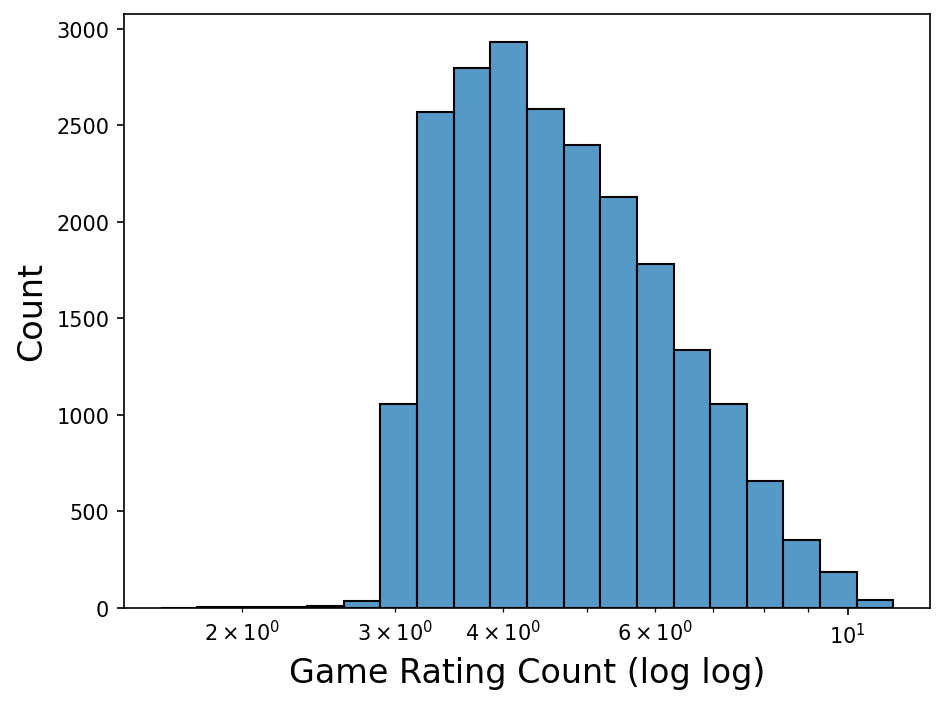

In [32]:
plot = sns.histplot(x=np.log(game_avg_rating_df.game_rating_count), bins=20, log_scale=True)
plot.set_xlabel('Game Rating Count (log log)')
plt.show()

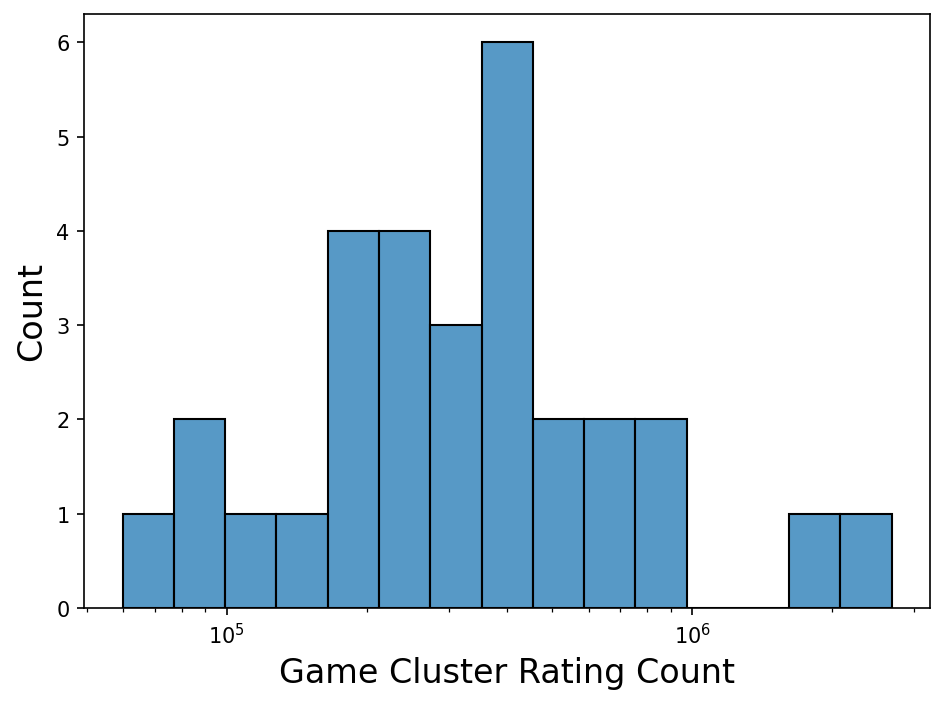

In [33]:
plot = sns.histplot(x=game_cluster_avg_rating_df.game_cluster_rating_count, bins=15, log_scale=True)
plot.set_xlabel('Game Cluster Rating Count')
plt.show()

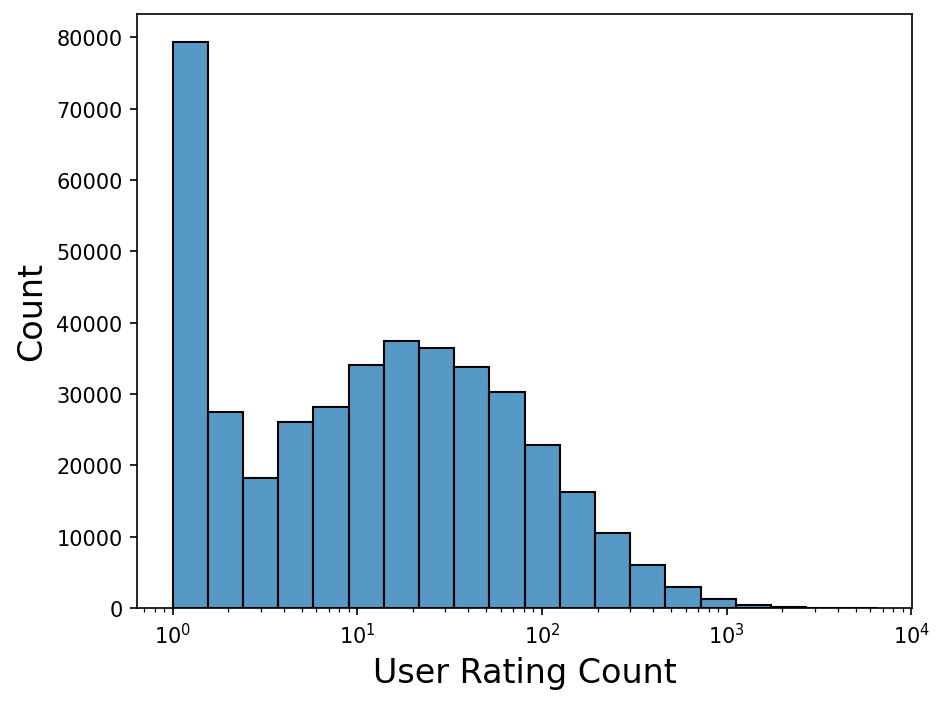

In [34]:
plot = sns.histplot(x=counts_df.Rating, bins=20, log_scale=True)
plot.set_xlabel('User Rating Count')
plt.show()

In summary:
* Game Rating Count - Log Log
* Game Cluster Rating Count - Log
* User Rating Count - Log

## Part 4 - Feature Transformation, Imputation, and Scaling

Now we will join our rating data with our supplementary board game data (content features) and user data (engineered features).

In [35]:
# Gather the user columns
user_rating_bucket_count_columns = [f"rating_bucket_{rating}_count" for rating in range(1, 11)]
user_rating_bucket_ratio_columns = [f"rating_bucket_{rating}_ratio" for rating in range(1, 11)]
user_cluster_count_columns = [f"{column}_count" for column in cluster_columns]
user_cluster_ratio_columns = [f"{column}_ratio" for column in cluster_columns]
user_cluster_avg_rating_columns = [f"{column}_avg_rating" for column in cluster_columns]
user_columns = \
    ['rating_bucket_total_count', 'user_avg_rating', 'user_min_rating', 'user_max_rating'] + \
    user_rating_bucket_count_columns + \
    user_rating_bucket_ratio_columns + \
    user_cluster_count_columns + \
    user_cluster_ratio_columns + \
    user_cluster_avg_rating_columns
print(f"{len(user_columns):,} total user features")

# Gather the game/cluster columns
game_rating_bucket_count_columns = [f"game_rating_bucket_{rating}_count" for rating in range(1, 11)]
game_rating_bucket_ratio_columns = [f"game_rating_bucket_{rating}_ratio" for rating in range(1, 11)]
game_columns = \
    cluster_columns + \
    ['game_rating_count', 'game_avg_rating', 'game_min_rating', 'game_max_rating'] + \
    game_rating_bucket_count_columns + \
    game_rating_bucket_ratio_columns
game_cluster_rating_bucket_count_columns = [f"game_cluster_rating_bucket_{rating}_count" for rating in range(1, 11)]
game_cluster_rating_bucket_ratio_columns = [f"game_cluster_rating_bucket_{rating}_ratio" for rating in range(1, 11)]
game_cluster_columns = \
    ['game_cluster_rating_count', 'game_cluster_avg_rating', 'game_cluster_min_rating', 'game_cluster_max_rating'] + \
    game_cluster_rating_bucket_count_columns + \
    game_cluster_rating_bucket_ratio_columns
print(f"{len(game_columns):,} game features and {len(game_cluster_columns):,} as game cluster features")
all_game_columns = game_columns + game_cluster_columns
print(f"{len(all_game_columns):,} total game features (including cluster features)")

train_columns = user_columns + all_game_columns
n_features = len(train_columns)
print(f"Training columns (total features): {n_features:,}")

114 total user features
54 game features and 24 as game cluster features
78 total game features (including cluster features)
Training columns (total features): 192


In [36]:
full_train_df = train_df\
    .merge(cluster_counts_df, on='username_id')\
    .merge(train_avg_rating_df, on='username_id')\
    .merge(user_rating_bucket_counts_df, on='username_id')\
    .merge(cgames_df, on='BGGId')\
    .merge(game_avg_rating_df, on='BGGId')\
    .merge(game_cluster_avg_rating_df, on='cluster')\
    [['Rating'] + train_columns]
full_train_df

,Rating,rating_bucket_total_count,user_avg_rating,user_min_rating,user_max_rating,rating_bucket_1_count,rating_bucket_2_count,rating_bucket_3_count,rating_bucket_4_count,rating_bucket_5_count,...,game_cluster_rating_bucket_1_ratio,game_cluster_rating_bucket_2_ratio,game_cluster_rating_bucket_3_ratio,game_cluster_rating_bucket_4_ratio,game_cluster_rating_bucket_5_ratio,game_cluster_rating_bucket_6_ratio,game_cluster_rating_bucket_7_ratio,game_cluster_rating_bucket_8_ratio,game_cluster_rating_bucket_9_ratio,game_cluster_rating_bucket_10_ratio
0,8.0,20,7.040000,4.0,10.0,0,0,0,1,0,...,0.003611,0.007328,0.017343,0.037139,0.084251,0.188099,0.289033,0.232892,0.098797,0.041507
1,8.0,44,7.409091,3.0,9.0,0,0,1,0,1,...,0.003611,0.007328,0.017343,0.037139,0.084251,0.188099,0.289033,0.232892,0.098797,0.041507
2,8.0,57,7.938596,6.0,10.0,0,0,0,0,0,...,0.003611,0.007328,0.017343,0.037139,0.084251,0.188099,0.289033,0.232892,0.098797,0.041507
3,8.0,55,7.854545,3.0,10.0,0,0,1,0,1,...,0.003611,0.007328,0.017343,0.037139,0.084251,0.188099,0.289033,0.232892,0.098797,0.041507
4,8.0,345,7.247826,3.0,10.0,0,0,1,6,11,...,0.003611,0.007328,0.017343,0.037139,0.084251,0.188099,0.289033,0.232892,0.098797,0.041507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14119515,4.0,385,6.275325,2.0,10.0,0,4,11,40,58,...,0.007626,0.013007,0.026806,0.053203,0.108846,0.209886,0.269442,0.199121,0.077515,0.034549
14119516,3.0,2415,5.249275,1.0,10.0,30,135,368,293,383,...,0.007626,0.013007,0.026806,0.053203,0.108846,0.209886,0.269442,0.199121,0.077515,0.034549
14119517,3.0,29,6.862069,3.0,10.0,0,0,2,1,5,...,0.007626,0.013007,0.026806,0.053203,0.108846,0.209886,0.269442,0.199121,0.077515,0.034549
14119518,1.0,18,7.722222,1.0,9.0,1,0,0,0,0,...,0.001331,0.003437,0.008725,0.023126,0.061777,0.164113,0.308395,0.276319,0.110712,0.042065


In [37]:
bit_columns = cluster_columns
std_numeric_columns = [
    'game_avg_rating',
    'game_min_rating',
    'game_max_rating',
    'game_cluster_avg_rating',
    'game_cluster_min_rating',
    'game_cluster_max_rating',
    'user_avg_rating'
] + \
    user_cluster_avg_rating_columns + \
    user_cluster_ratio_columns + \
    user_rating_bucket_ratio_columns + \
    game_rating_bucket_ratio_columns + \
    game_cluster_rating_bucket_ratio_columns
log_numeric_columns = list(set(train_columns) - set(bit_columns + std_numeric_columns))

print(f"{len(log_numeric_columns)} log features, {len(std_numeric_columns)} numeric features, {len(bit_columns)} bit features")

ss = StandardScaler()
powx = PowerTransformer('yeo-johnson')
colx = ColumnTransformer(
    transformers=[
        ('standard', ss, std_numeric_columns),
        ('log', powx, log_numeric_columns)
    ]
)

scaled_values = colx.fit_transform(full_train_df[std_numeric_columns + log_numeric_columns])
trainY = full_train_df.Rating
trainX = np.hstack((full_train_df[bit_columns], scaled_values))
print(f"Train X {trainX.shape}, Train Y {trainY.shape[0]}")

65 log features, 97 numeric features, 30 bit features
Train X (14119520, 192), Train Y 14119520


In [38]:
full_test_df = unseen_df\
    .merge(test_cluster_counts_df, on='username_id')\
    .merge(test_avg_rating_df, on='username_id')\
    .merge(test_user_rating_bucket_counts_df, on='username_id')\
    .merge(cgames_df, on='BGGId')\
    .merge(game_avg_rating_df, on='BGGId')\
    .merge(game_cluster_avg_rating_df, on='cluster')\
    [['Rating'] + train_columns]
full_test_df

,Rating,rating_bucket_total_count,user_avg_rating,user_min_rating,user_max_rating,rating_bucket_1_count,rating_bucket_2_count,rating_bucket_3_count,rating_bucket_4_count,rating_bucket_5_count,...,game_cluster_rating_bucket_1_ratio,game_cluster_rating_bucket_2_ratio,game_cluster_rating_bucket_3_ratio,game_cluster_rating_bucket_4_ratio,game_cluster_rating_bucket_5_ratio,game_cluster_rating_bucket_6_ratio,game_cluster_rating_bucket_7_ratio,game_cluster_rating_bucket_8_ratio,game_cluster_rating_bucket_9_ratio,game_cluster_rating_bucket_10_ratio
0,6.0,239,7.031799,1.0,10.0,1,2,2,5,19,...,0.003611,0.007328,0.017343,0.037139,0.084251,0.188099,0.289033,0.232892,0.098797,0.041507
1,7.0,154,7.142857,4.0,9.0,0,0,0,1,3,...,0.003611,0.007328,0.017343,0.037139,0.084251,0.188099,0.289033,0.232892,0.098797,0.041507
2,5.0,1144,6.095280,1.0,10.0,3,15,37,127,229,...,0.000657,0.001858,0.006175,0.018833,0.057102,0.162405,0.320146,0.289642,0.106999,0.036184
3,7.0,35,7.342857,4.0,10.0,0,0,0,1,2,...,0.000657,0.001858,0.006175,0.018833,0.057102,0.162405,0.320146,0.289642,0.106999,0.036184
4,7.0,115,7.904348,4.0,10.0,0,0,0,1,0,...,0.006019,0.011373,0.025753,0.051791,0.109792,0.214406,0.268925,0.197949,0.077747,0.036245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185845,6.0,154,5.737013,2.0,10.0,0,15,0,35,2,...,0.000784,0.001671,0.005640,0.014546,0.038930,0.106320,0.239220,0.315527,0.193424,0.083938
1185846,5.0,813,6.701107,2.0,10.0,0,3,8,23,52,...,0.006145,0.010036,0.019450,0.040092,0.090993,0.194242,0.286912,0.228762,0.086473,0.036894
1185847,6.0,46,6.540217,2.0,10.0,0,1,1,4,3,...,0.000657,0.001858,0.006175,0.018833,0.057102,0.162405,0.320146,0.289642,0.106999,0.036184
1185848,7.0,265,7.057736,2.0,9.5,0,2,6,10,16,...,0.004909,0.010124,0.023587,0.047330,0.102606,0.208015,0.278909,0.208123,0.081676,0.034721


In [39]:
test_scaled_values = colx.transform(full_test_df[std_numeric_columns + log_numeric_columns])
testY = full_test_df.Rating
testX = np.hstack((full_test_df[bit_columns], test_scaled_values))
print(f"Test X {testX.shape}, Test Y {testY.shape[0]}")

Test X (1185850, 192), Test Y 1185850


## Part 5 - Model Selection and Evaluation

Let us start with a Random Forest Regression model.

In [40]:
rf = RandomForestRegressor(random_state=777, max_depth=6, n_estimators=16, n_jobs=-1)
rf.fit(trainX, trainY)

RandomForestRegressor(max_depth=6, n_estimators=16, n_jobs=-1, random_state=777)

In [41]:
# The above took 38m to train
predY = rf.predict(testX)

In [42]:
def ComputeR2(true, pred):
    result = linregress(true, pred)
    rvalue = result.rvalue
    return rvalue * rvalue

In [43]:
rf_r2 = ComputeR2(testY, predY)
print(f"Random Forest R^2: {rf_r2:.2}")
print(f"Unseen rating min: {testY.min()}, max {testY.max()}, mean {testY.mean()}")
print(f"Predicted min: {predY.min()}, max {predY.max()}, mean {predY.mean()}")

Random Forest R^2: 0.38
Unseen rating min: 0.001, max 10.0, mean 7.119521186861745
Predicted min: 2.4714937338955276, max 9.976127802038016, mean 7.1215977709630955


Now let us try a multi-layer perceptron.

In [44]:
mlp = MLPRegressor(
    random_state=777,
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=1000,
    learning_rate_init=0.001,
    max_iter=3,
    tol=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    verbose=True
)
mlp.fit(trainX, trainY)

Iteration 1, loss = 0.62897172
Iteration 2, loss = 0.53230121
Iteration 3, loss = 0.52597693


C:\git\csc6711\project5\msoe\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(batch_size=1000, max_iter=3, random_state=777, verbose=True)

In [45]:
mlp_predY = mlp.predict(testX)

In [57]:
mlp_r2 = ComputeR2(testY, mlp_predY)
print(f"MLP R^2: {mlp_r2:.2}")
print(f"Unseen rating min: {testY.min()}, max {testY.max()}, mean {testY.mean()}")
print(f"Predicted min: {mlp_predY.min()}, max {mlp_predY.max()}, mean {mlp_predY.mean()}")

MLP R^2: 0.36
Unseen rating min: 0.001, max 10.0, mean 7.119521186861745
Predicted min: -2.1259895500352872, max 11.652240603464039, mean 7.114081291440798


Using the MLP regressor seems a littly clunky compared to my previous experience with keras.  Let me try making a custom pipeline.

In [47]:
def plot_loss_r2(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='Training R^2')
    plt.plot(history.history['val_r2_score'], label='Validation R^2')
    plt.title('Training and Validation R^2')
    plt.xlabel('Epoch')
    plt.ylabel('R^2')
    plt.legend()

    plt.tight_layout()
    plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │          19,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,401 (75.79 KB)

 Trainable params: 19,401 (75.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 1.8991 - r2_score: 0.1445 - val_loss: 1.3368 - val_r2_score: 0.5223
Epoch 2/3
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 10s 850us/step - loss: 1.0272 - r2_score: 0.5360 - val_loss: 1.2760 - val_r2_score: 0.5440
Epoch 3/3
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 10s 846us/step - loss: 1.0079 - r2_score: 0.5446 - val_loss: 1.3001 - val_r2_score: 0.5354


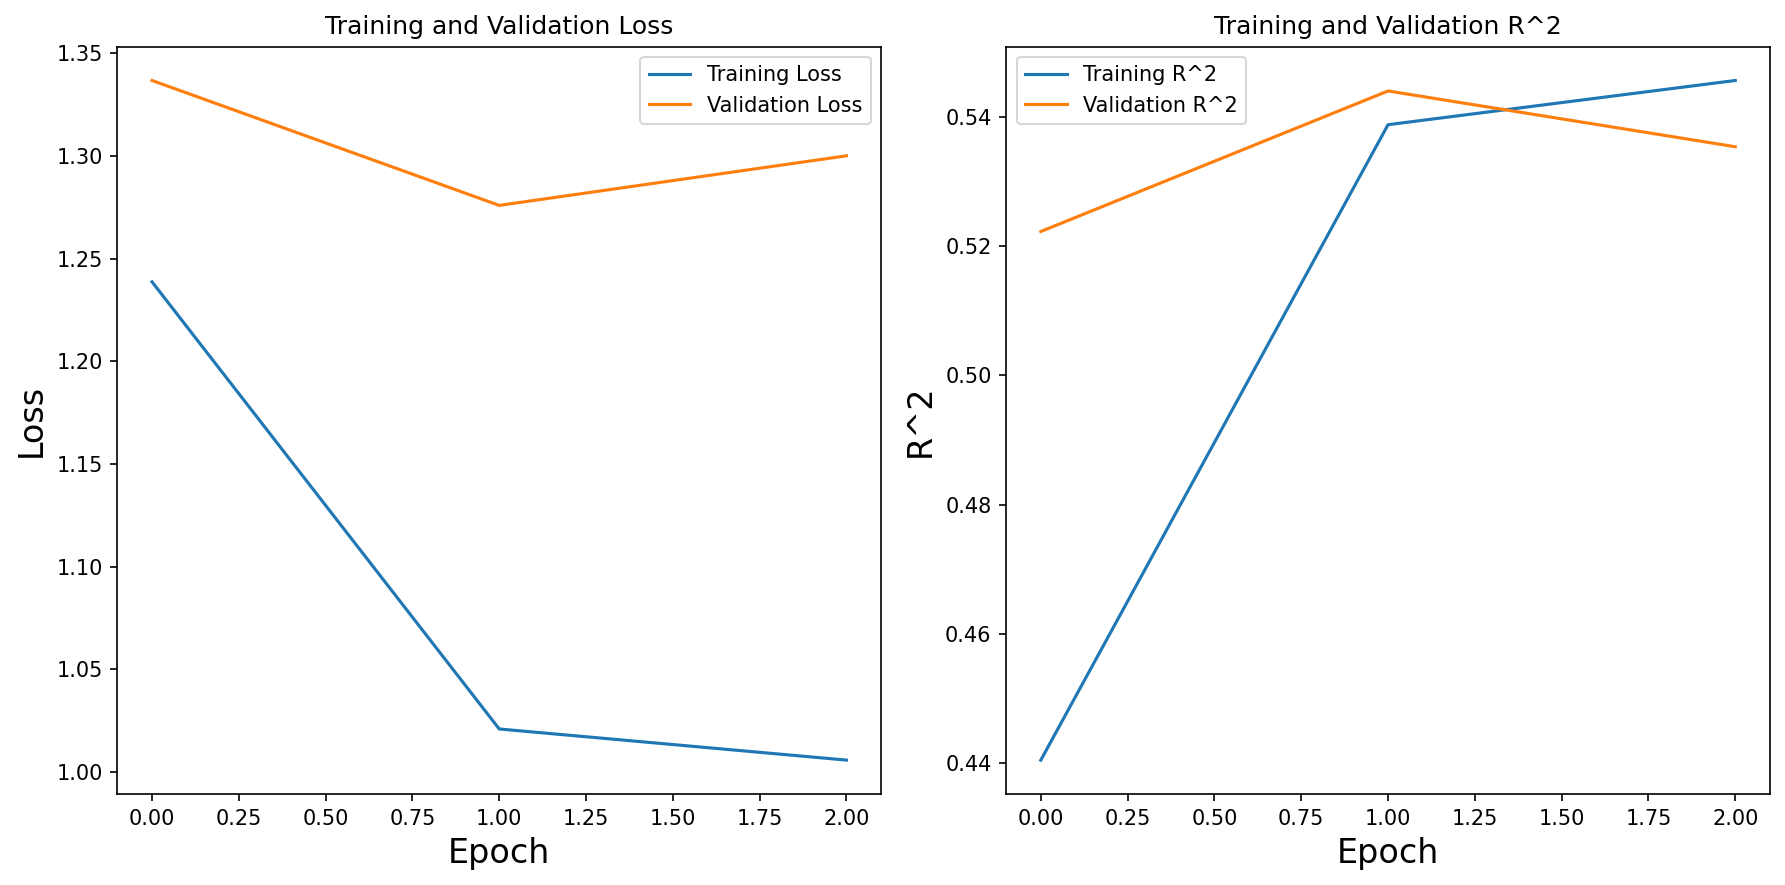

Test R^2: 0.35


In [48]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=3, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,313 (364.50 KB)

 Trainable params: 93,313 (364.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.5438 - r2_score: 0.3028 - val_loss: 1.2755 - val_r2_score: 0.5442
Epoch 2/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.9942 - r2_score: 0.5509 - val_loss: 1.2540 - val_r2_score: 0.5519
Epoch 3/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.9801 - r2_score: 0.5571 - val_loss: 1.2502 - val_r2_score: 0.5533
Epoch 4/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.9711 - r2_score: 0.5612 - val_loss: 1.2273 - val_r2_score: 0.5614


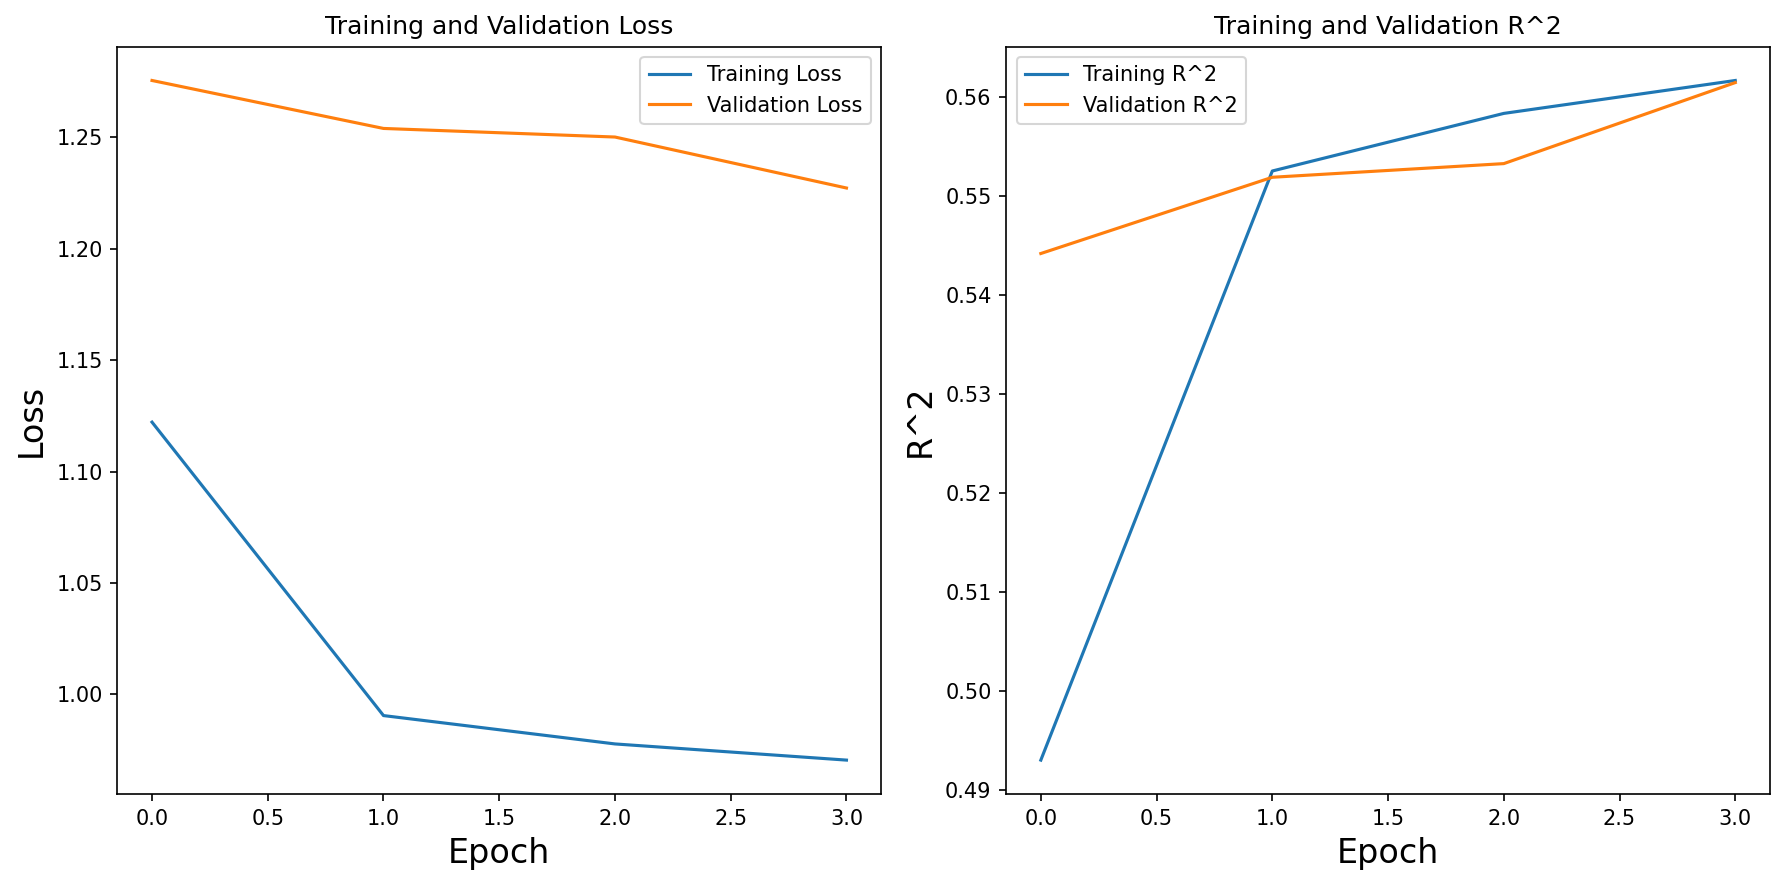

Test R^2: 0.33


In [49]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=4, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,105 (113.69 KB)

 Trainable params: 29,105 (113.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 1.6261 - r2_score: 0.2664 - val_loss: 1.3206 - val_r2_score: 0.5281
Epoch 2/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1.0102 - r2_score: 0.5436 - val_loss: 1.2846 - val_r2_score: 0.5410
Epoch 3/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.9924 - r2_score: 0.5514 - val_loss: 1.2477 - val_r2_score: 0.5541
Epoch 4/4
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.9850 - r2_score: 0.5548 - val_loss: 1.2628 - val_r2_score: 0.5487


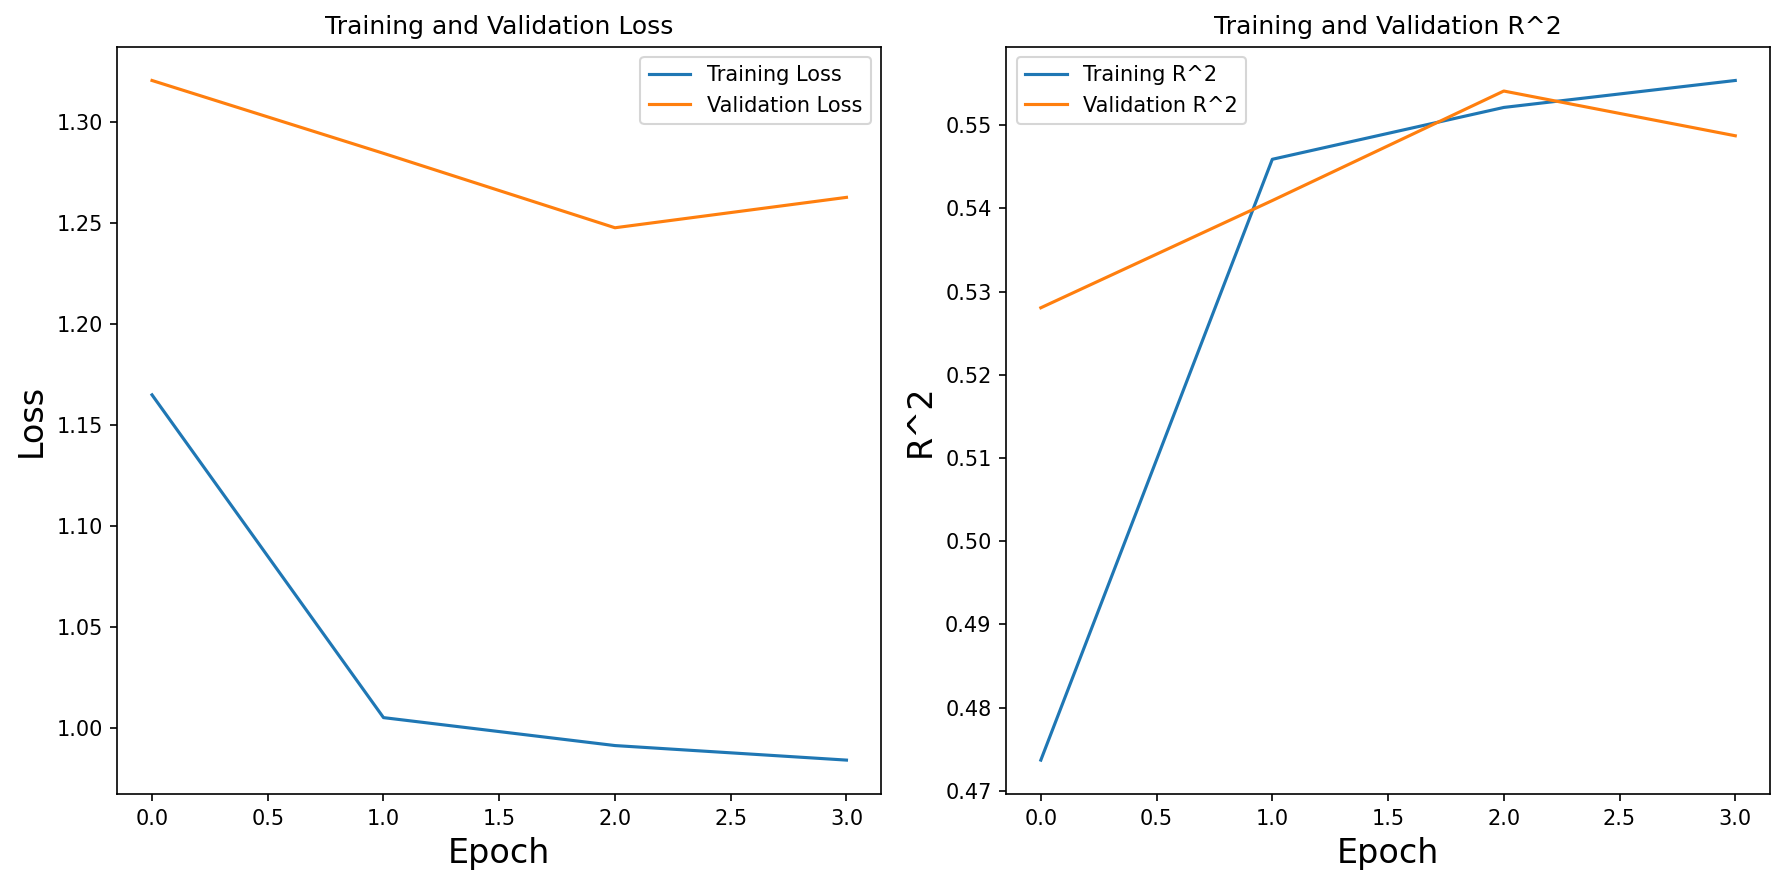

Test R^2: 0.33


In [50]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=4, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 200)                 │          38,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,801 (151.57 KB)

 Trainable params: 38,801 (151.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 1.6324 - r2_score: 0.2642 - val_loss: 1.2983 - val_r2_score: 0.5360
Epoch 2/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 1.0130 - r2_score: 0.5427 - val_loss: 1.2724 - val_r2_score: 0.5453
Epoch 3/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.9984 - r2_score: 0.5489 - val_loss: 1.2640 - val_r2_score: 0.5483
Epoch 4/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.9915 - r2_score: 0.5519 - val_loss: 1.2598 - val_r2_score: 0.5498
Epoch 5/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.9879 - r2_score: 0.5538 - val_loss: 1.2562 - val_r2_score: 0.5511
Epoch 6/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.9844 - r2_score: 0.5548 - val_loss: 1.2529 - val_r2_score: 0.5523


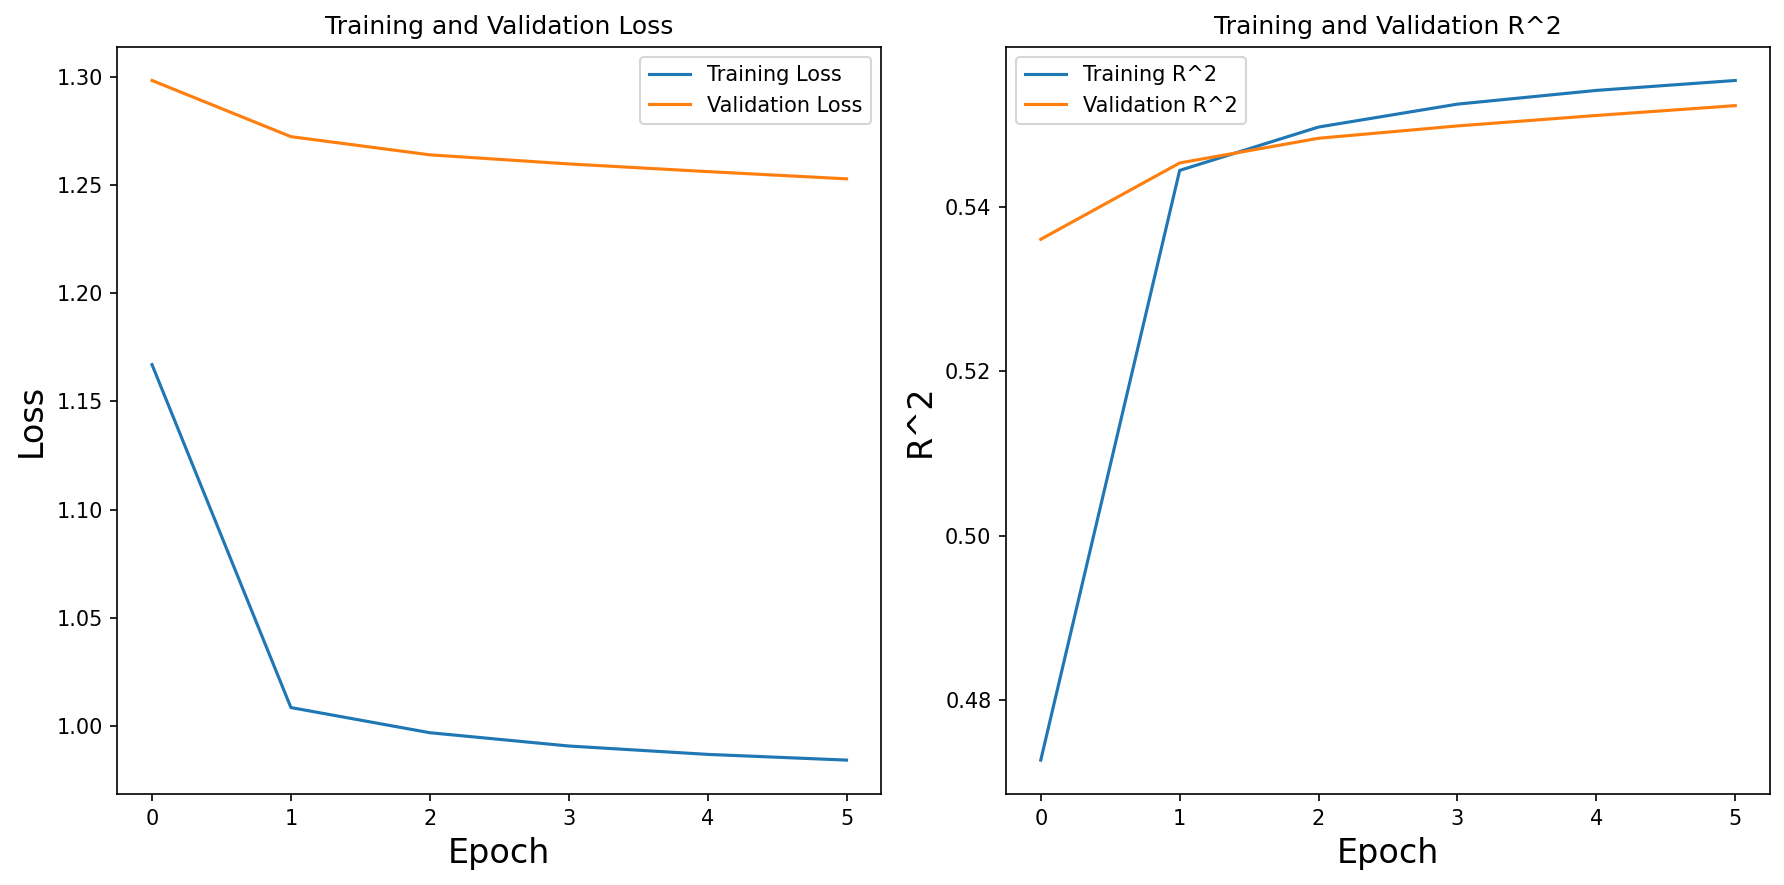

Test R^2: 0.34


In [51]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(200, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=6, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 200)                 │          38,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,801 (229.69 KB)

 Trainable params: 58,801 (229.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 1.6787 - r2_score: 0.2433 - val_loss: 1.3152 - val_r2_score: 0.5300
Epoch 2/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.1079 - r2_score: 0.4998 - val_loss: 1.2888 - val_r2_score: 0.5394
Epoch 3/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.0500 - r2_score: 0.5254 - val_loss: 1.2646 - val_r2_score: 0.5481
Epoch 4/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.0278 - r2_score: 0.5358 - val_loss: 1.2606 - val_r2_score: 0.5495
Epoch 5/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.0163 - r2_score: 0.5407 - val_loss: 1.2591 - val_r2_score: 0.5501
Epoch 6/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.0103 - r2_score: 0.5433 - val_loss: 1.2508 - val_r2_score: 0.5530


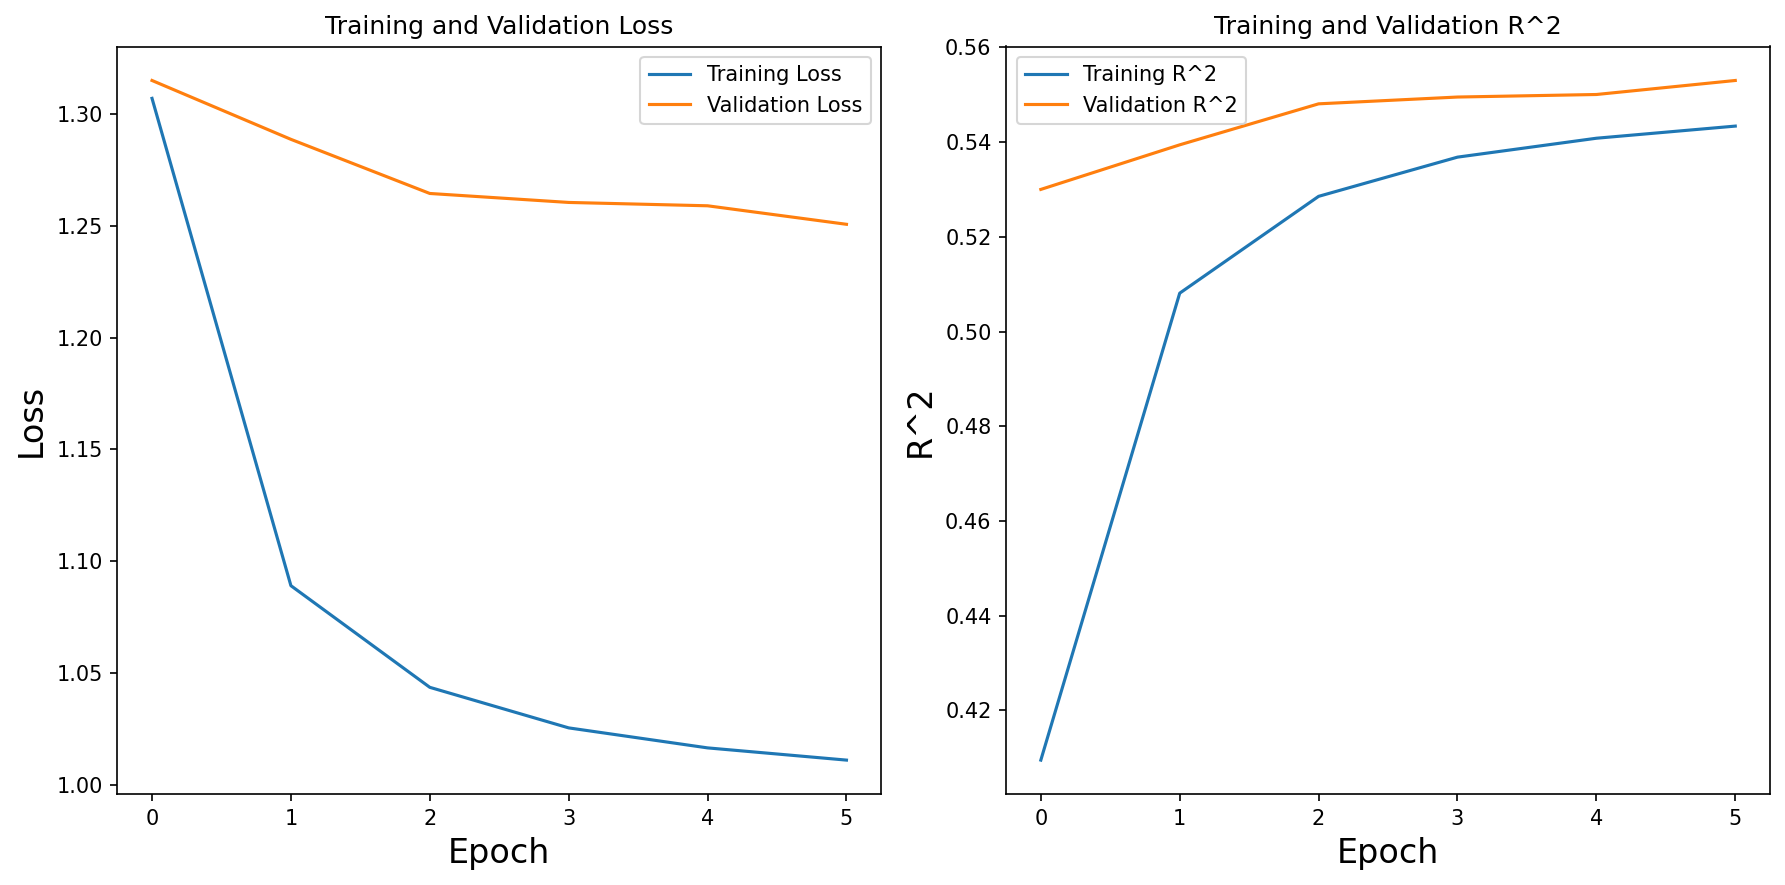

Test R^2: 0.36


In [52]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(200, activation='relu'),
    Dropout(0.10),
    Dense(100, activation='relu'),
    Dropout(0.10),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=6, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,313 (364.50 KB)

 Trainable params: 93,313 (364.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2.7456 - r2_score: -0.2409 - val_loss: 1.3896 - val_r2_score: 0.5034
Epoch 2/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 1.0876 - r2_score: 0.5084 - val_loss: 1.4002 - val_r2_score: 0.4996
Epoch 3/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 1.0603 - r2_score: 0.5207 - val_loss: 1.3830 - val_r2_score: 0.5058
Epoch 4/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 1.0521 - r2_score: 0.5244 - val_loss: 1.3845 - val_r2_score: 0.5052
Epoch 5/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 1.0479 - r2_score: 0.5262 - val_loss: 1.4173 - val_r2_score: 0.4935
Epoch 6/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 1.0447 - r2_score: 0.5278 - val_loss: 1.3944 - val_r2_score: 0.5017


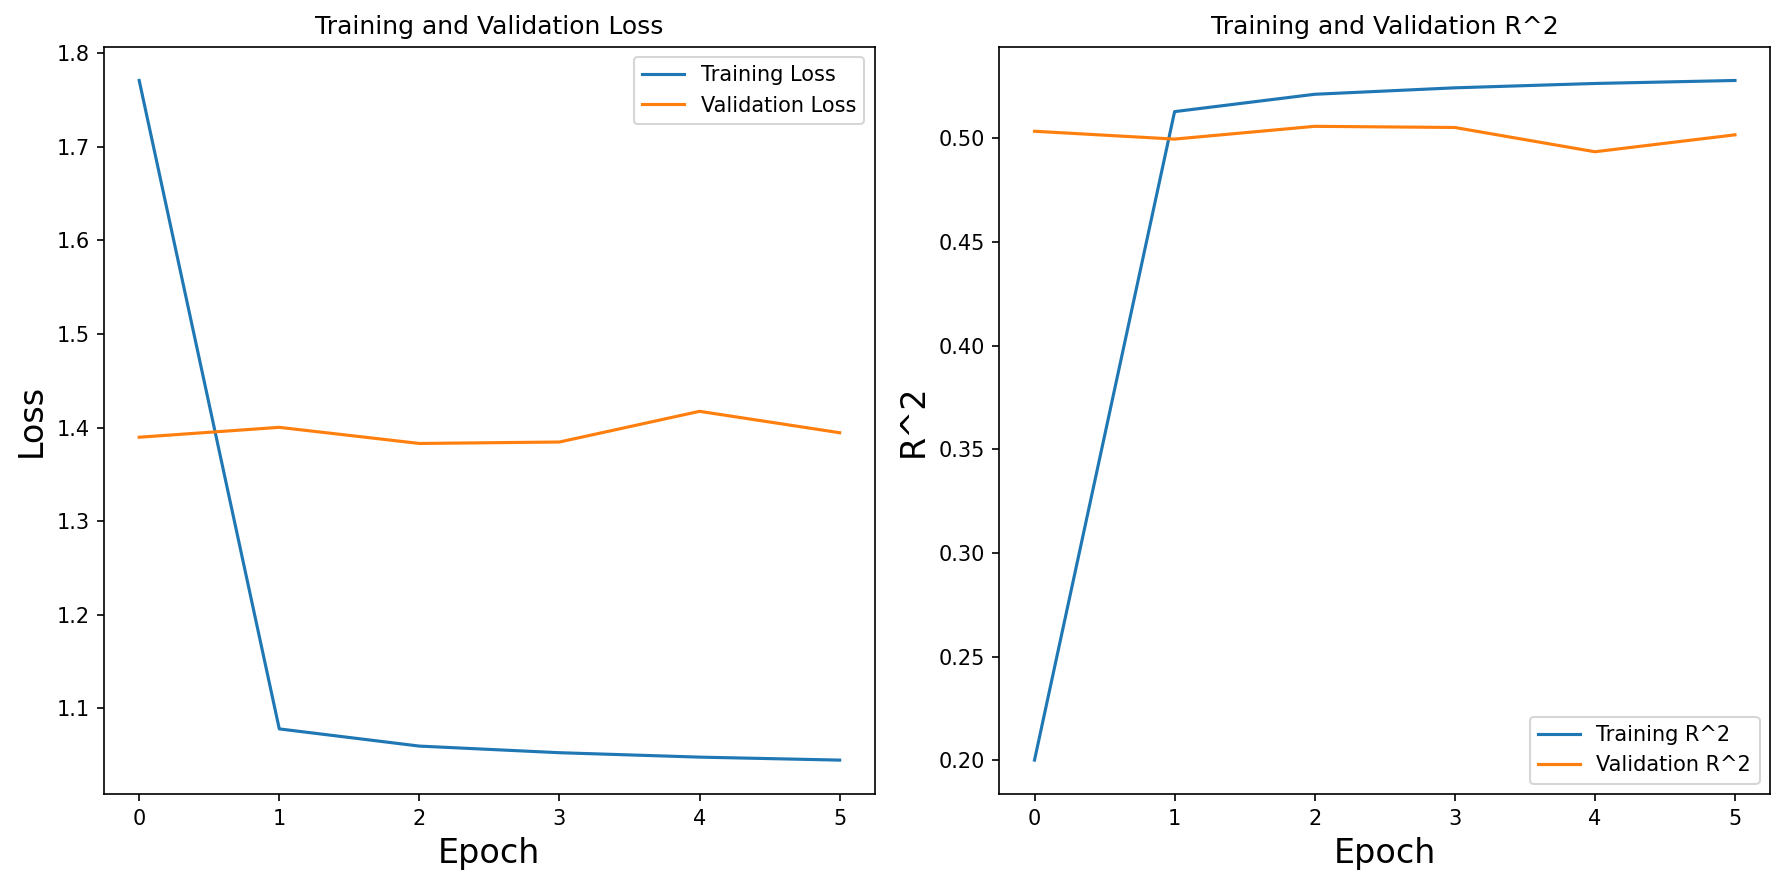

Test R^2: 0.34


In [53]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(256, activation='relu'),
    Dropout(0.10),
    Dense(128, activation='relu'),
    Dropout(0.10),
    Dense(64, activation='relu'),
    Dropout(0.10),
    Dense(32, activation='relu'),
    Dropout(0.10),
    Dense(16, activation='relu'),
    Dropout(0.10),
    Dense(8, activation='relu'),
    Dropout(0.10),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=6, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 200)                 │          38,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,401 (622.66 KB)

 Trainable params: 159,401 (622.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 1.5026 - r2_score: 0.3223 - val_loss: 1.3570 - val_r2_score: 0.5151
Epoch 2/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 1.0521 - r2_score: 0.5252 - val_loss: 1.3009 - val_r2_score: 0.5351
Epoch 3/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 1.0019 - r2_score: 0.5472 - val_loss: 1.2787 - val_r2_score: 0.5430
Epoch 4/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.9795 - r2_score: 0.5574 - val_loss: 1.2762 - val_r2_score: 0.5440
Epoch 5/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.9706 - r2_score: 0.5619 - val_loss: 1.2673 - val_r2_score: 0.5471
Epoch 6/6
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.9650 - r2_score: 0.5644 - val_loss: 1.2775 - val_r2_score: 0.5435


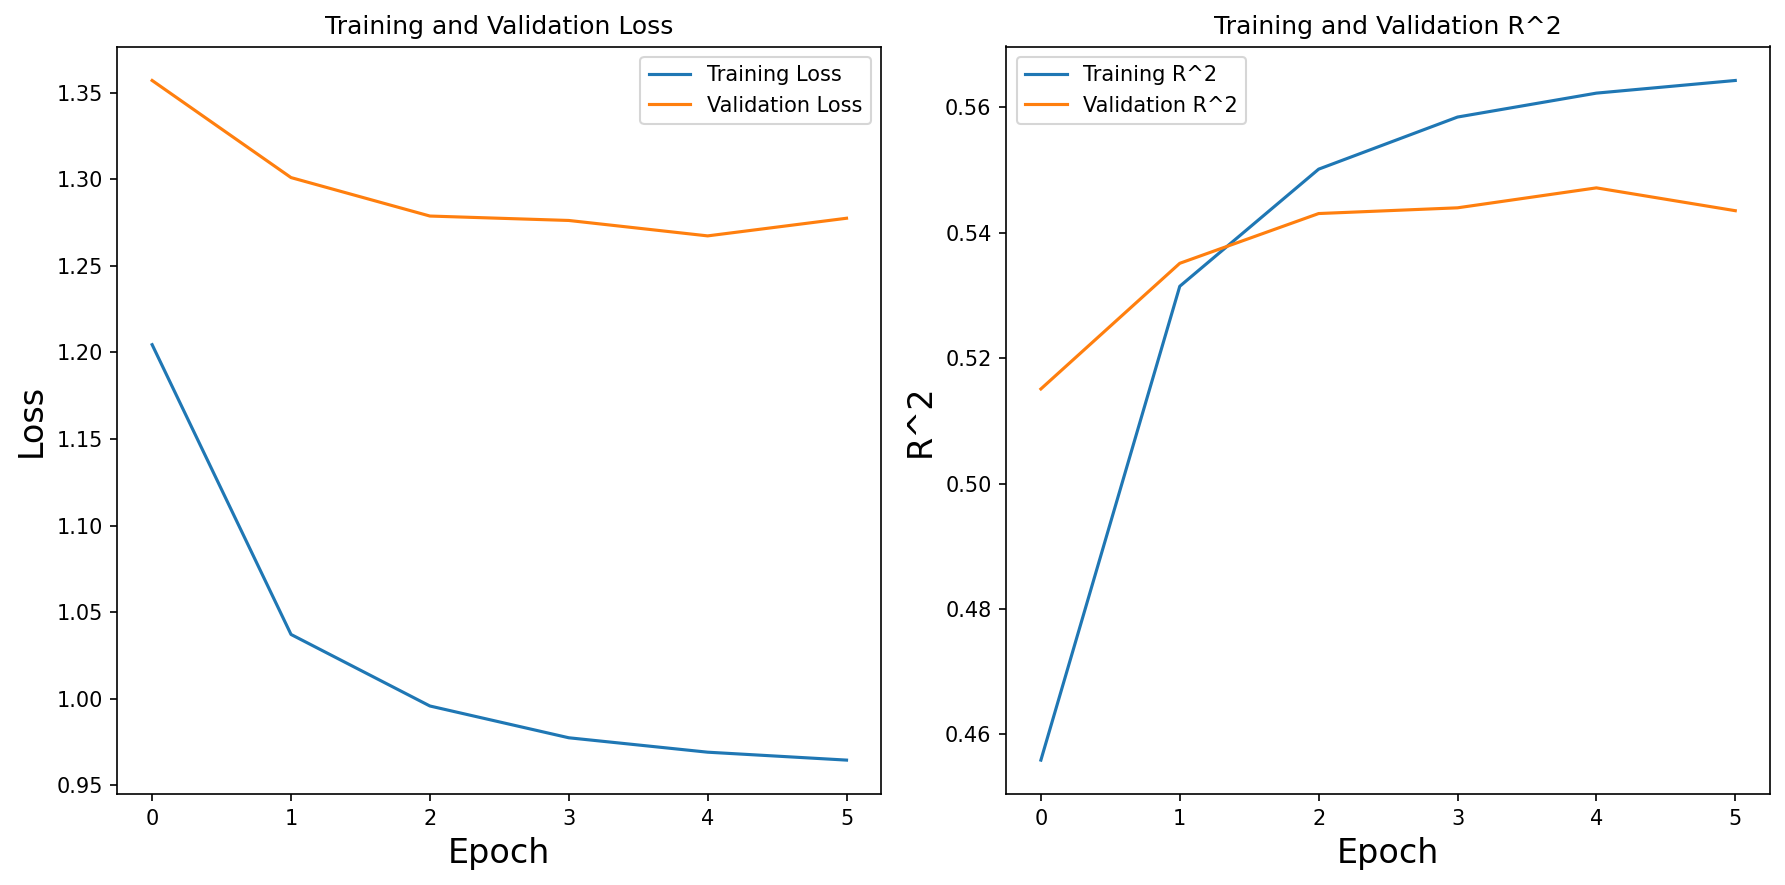

Test R^2: 0.34


In [54]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(200, activation='relu'),
    Dense(200, activation='relu'),
    Dense(200, activation='relu'),
    Dropout(0.10),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(0.10),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=6, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 200)                 │          38,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,801 (229.69 KB)

 Trainable params: 58,801 (229.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 1.6024 - r2_score: 0.2769 - val_loss: 1.3527 - val_r2_score: 0.5166
Epoch 2/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.1005 - r2_score: 0.5025 - val_loss: 1.2864 - val_r2_score: 0.5403
Epoch 3/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.0466 - r2_score: 0.5273 - val_loss: 1.2632 - val_r2_score: 0.5486
Epoch 4/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.0258 - r2_score: 0.5369 - val_loss: 1.2687 - val_r2_score: 0.5466
Epoch 5/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.0158 - r2_score: 0.5408 - val_loss: 1.2566 - val_r2_score: 0.5509
Epoch 6/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.0098 - r2_score: 0.5442 - val_loss: 1.2541 - val_r2_score: 0.5518
Epoch 7/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.0065 - r2_score: 0.5455 - val_loss: 1.2451 - val_r2_score: 0.5551
Epoch 8/12
11296/11296 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.00

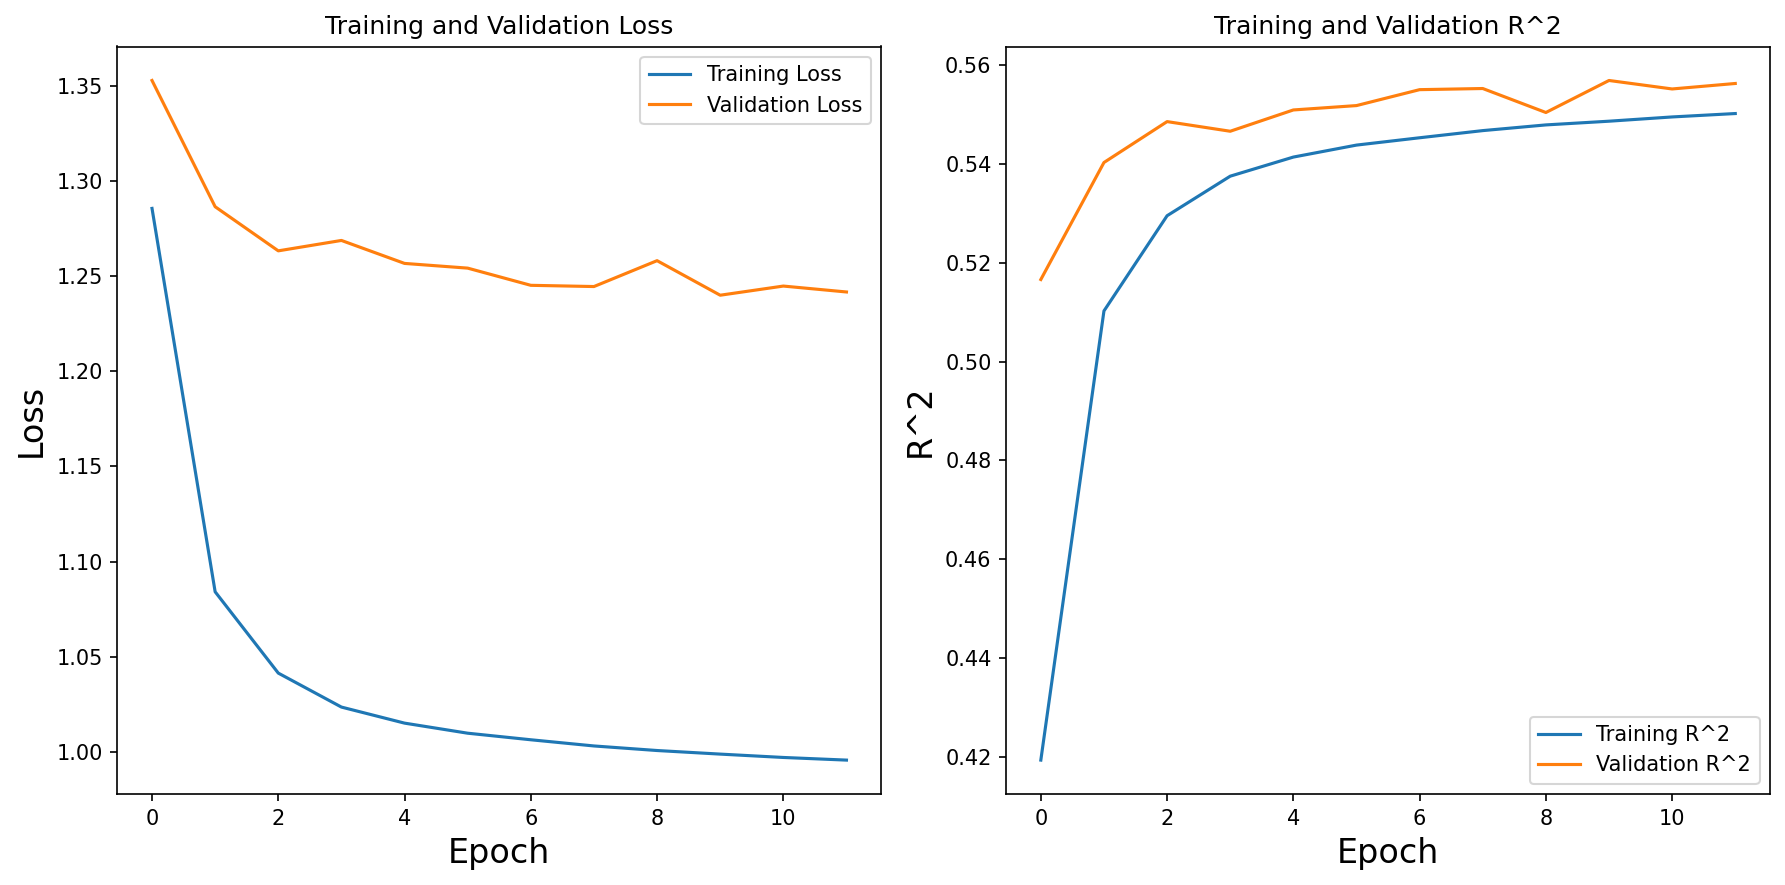

Test R^2: 0.35


In [55]:
model = Sequential([
    Input(shape=(n_features,)),
    Dense(200, activation='relu'),
    Dropout(0.10),
    Dense(100, activation='relu'),
    Dropout(0.10),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
model.summary()
history = model.fit(trainX, trainY, epochs=12, batch_size=1000, validation_split=0.2)
plot_loss_r2(history)
loss, metric = model.evaluate(testX, testY, verbose=0)
print(f"Test R^2: {metric:.2}")

## Part 6 - Analysis

Let us graph the predictions by user count histogram (log scale).

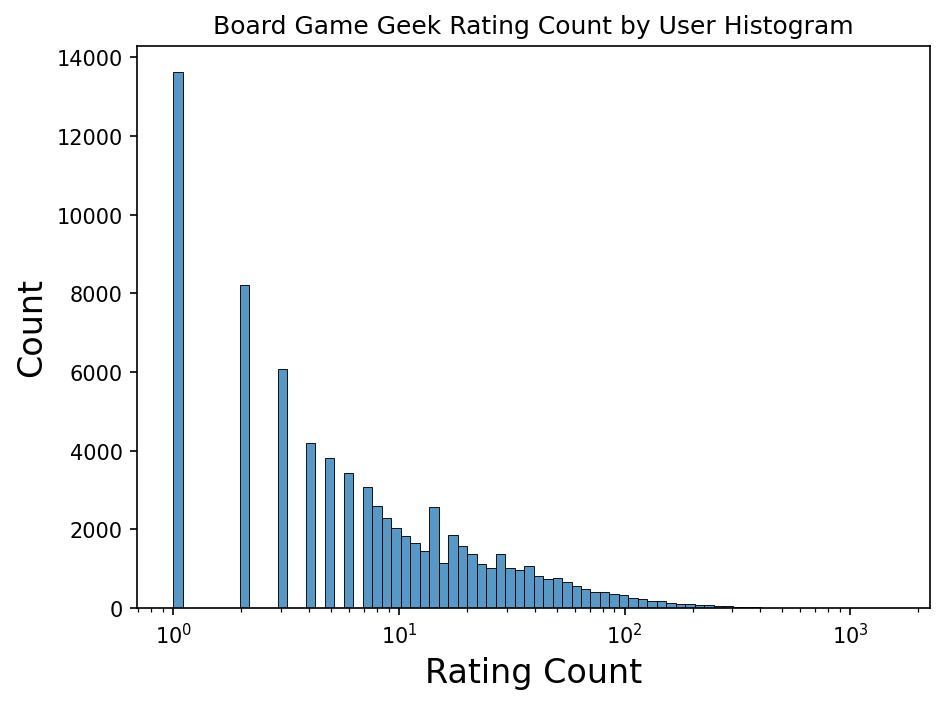

In [56]:
rating_count_by_user_df = unseen_df.groupby('username_id')[['Rating']].count()
plot = sns.histplot(x=rating_count_by_user_df['Rating'], log_scale=True)
plot.set(title=f"Board Game Geek Rating Count by User Histogram", xlabel="Rating Count")
plt.show()